<a href="https://colab.research.google.com/github/Evans-Sense/pet/blob/main/Hometask_2_MLPro2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Домашнее задание
Как узнать свою аудиторию? Построение различных вариантов кластеризаций и интерпретация результатов.

Цель:
На этот раз займемся классической задачкой - сегментация клиентов (в данном случае - банка). Крайне полезная операция, которая позволяет вам лучше познакомиться со своей аудиторией, понять, на какие группы она делится и чем они характеризуются.



In [57]:
import kagglehub
import os
from tqdm import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
import umap
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering, DBSCAN

from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import adjusted_rand_score

# Часть 1. EDA и Preprocessing.

Скачайте данные по клиентам немецкого банка: https://www.kaggle.com/uciml/german-credit;
Проведите EDA, чтобы познакомиться с признаками;
Преобразуйте все признаки в числовые подходящими методами;
Приведите все данные к одному масштабу (а заодно поясните, почему это необходимая операция при кластеризации).


In [58]:
path = kagglehub.dataset_download("uciml/german-credit")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'german-credit' dataset.
Path to dataset files: /kaggle/input/german-credit


In [59]:
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/german-credit/german_credit_data.csv


In [60]:
df= pd.read_csv('/root/.cache/kagglehub/datasets/uciml/german-credit/versions/1/german_credit_data.csv')

df.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
dtypes: int64(5), object(5)
memory usage: 78.3+ KB


In [62]:
df.nunique()

,0
Unnamed: 0,1000
Age,53
Sex,2
Job,4
Housing,3
Saving accounts,4
Checking account,3
Credit amount,921
Duration,33
Purpose,8


In [63]:
df.describe()

,Unnamed: 0,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,499.500000,35.546000,1.904000,3271.258000,20.903000
std,288.819436,11.375469,0.653614,2822.736876,12.058814
min,0.000000,19.000000,0.000000,250.000000,4.000000
25%,249.750000,27.000000,2.000000,1365.500000,12.000000
50%,499.500000,33.000000,2.000000,2319.500000,18.000000
75%,749.250000,42.000000,2.000000,3972.250000,24.000000
max,999.000000,75.000000,3.000000,18424.000000,72.000000


In [64]:
df_encoded = df.copy()
df_encoded = df_encoded.drop("Unnamed: 0", axis=1)
categorical_cols = df_encoded.select_dtypes(include='object').columns

df_encoded['Saving accounts'] = df_encoded['Saving accounts'].fillna('No saving accounts')
df_encoded['Checking account'] = df_encoded['Checking account'].fillna('No checking account')

for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])

print("DataFrame after encoding categorical features:")
print(df_encoded.head())
print("\nInformation about the encoded DataFrame:")
df_encoded.info()

DataFrame after encoding categorical features:
   Age  Sex  Job  Housing  Saving accounts  Checking account  Credit amount  \
0   67    1    2        1                0                 1           1169   
1   22    0    2        1                1                 2           5951   
2   49    1    1        1                1                 0           2096   
3   45    1    2        0                1                 1           7882   
4   53    1    2        0                1                 1           4870   

   Duration  Purpose  
0         6        5  
1        48        5  
2        12        3  
3        42        4  
4        24        1  

Information about the encoded DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Age               1000 non-null   int64
 1   Sex               1000 non-null   int64
 2   Job     

In [65]:
df_scaled = df_encoded.copy()

numerical_cols = df_scaled.select_dtypes(include=['int64', 'float64']).columns

scaler = StandardScaler()

df_scaled[numerical_cols] = scaler.fit_transform(df_scaled[numerical_cols])

print(df_scaled.head())

        Age       Sex       Job   Housing  Saving accounts  Checking account  \
0  2.766456  0.670280  0.146949 -0.133710        -1.231393         -0.001045   
1 -1.191404 -1.491914  0.146949 -0.133710        -0.196609          1.044372   
2  1.183312  0.670280 -1.383771 -0.133710        -0.196609         -1.046463   
3  0.831502  0.670280  0.146949 -2.016956        -0.196609         -0.001045   
4  1.535122  0.670280  0.146949 -2.016956        -0.196609         -0.001045   

   Credit amount  Duration   Purpose  
0      -0.745131 -1.236478  1.073263  
1       0.949817  2.248194  1.073263  
2      -0.416562 -0.738668  0.061705  
3       1.634247  1.750384  0.567484  
4       0.566664  0.256953 -0.949853  


In [66]:
pca = PCA(n_components=2)
pca.fit(df_scaled)
df_pca = pca.transform(df_scaled)

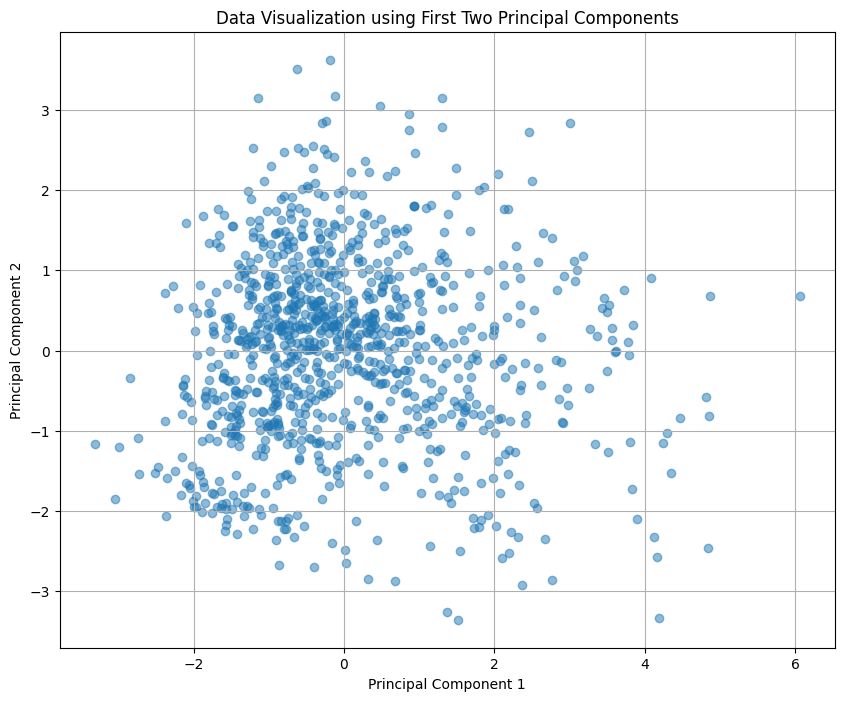

In [67]:
plt.figure(figsize=(10, 8))
plt.scatter(df_pca[:, 0], df_pca[:, 1], alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Data Visualization using First Two Principal Components')
plt.grid(True)
plt.show()

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr

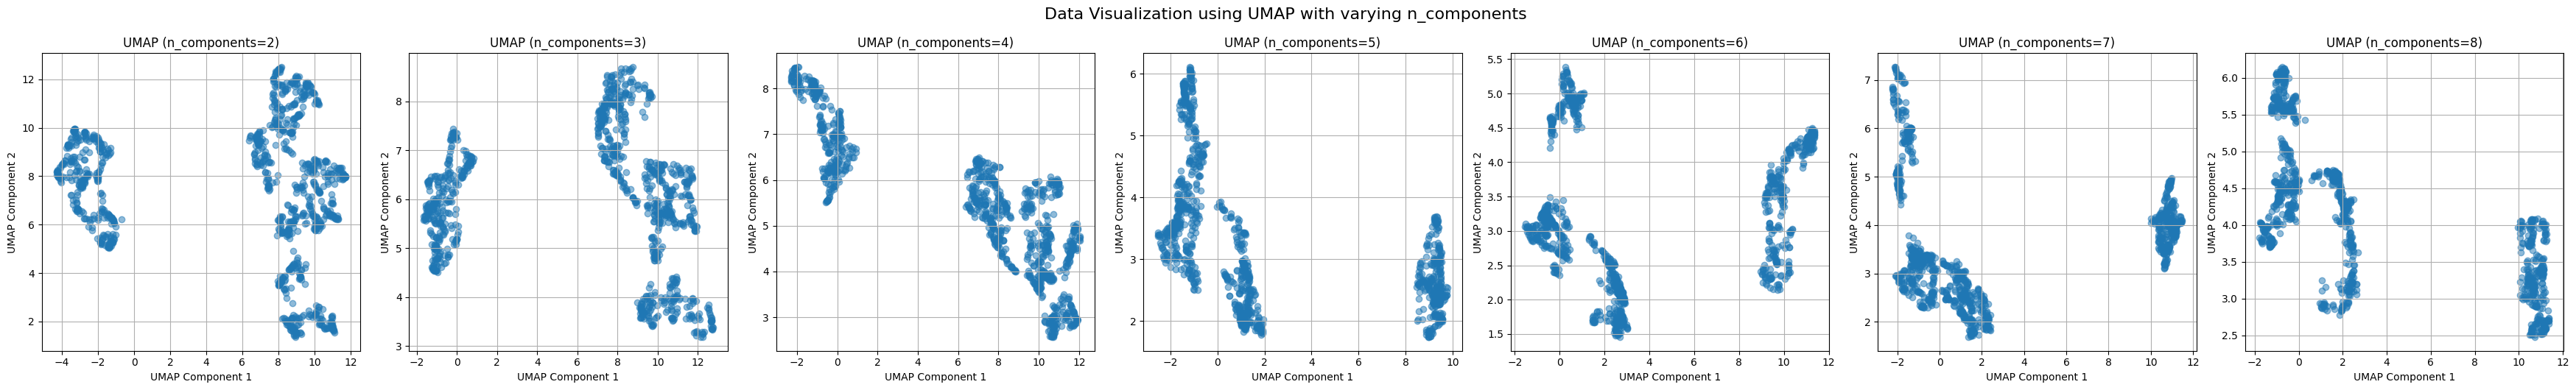

In [68]:
n_components_range = range(2, 9)

fig, axes = plt.subplots(1, len(n_components_range), figsize=(5 * len(n_components_range), 5))

if len(n_components_range) == 1:
    axes = [axes]

for i, n_components in enumerate(n_components_range):
    umap_reducer = umap.UMAP(n_components=n_components, random_state=42)
    df_umap_current = umap_reducer.fit_transform(df_scaled)

    ax = axes[i]
    ax.scatter(df_umap_current[:, 0], df_umap_current[:, 1], alpha=0.5)
    ax.set_xlabel('UMAP Component 1')
    ax.set_ylabel('UMAP Component 2')
    ax.set_title(f'UMAP (n_components={n_components})')
    ax.grid(True)

plt.tight_layout()
plt.suptitle('Data Visualization using UMAP with varying n_components', y=1.05, fontsize=16)
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


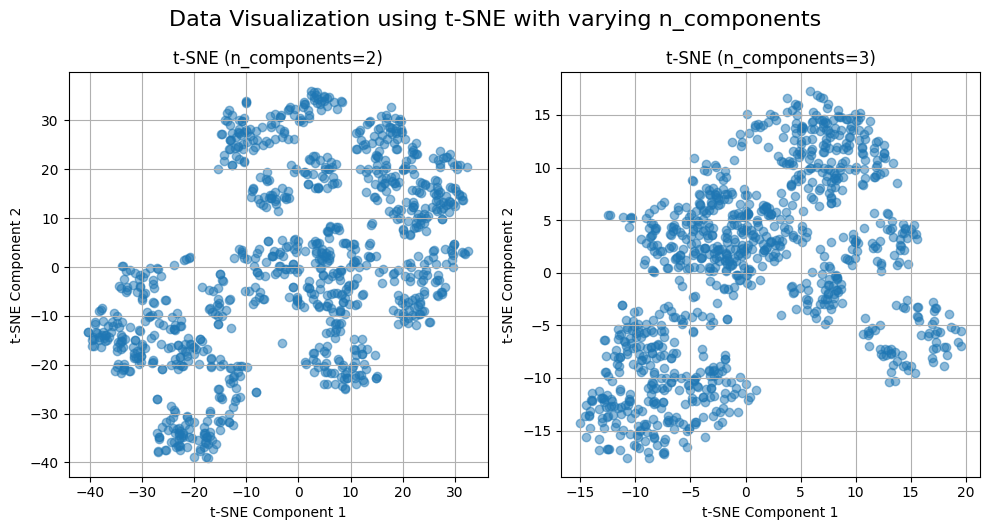

In [69]:
n_components_range = range(2, 4)

fig, axes = plt.subplots(1, len(n_components_range), figsize=(5 * len(n_components_range), 5))

if len(n_components_range) == 1:
    axes = [axes]

for i, n_components in enumerate(n_components_range):
    tsne = TSNE(n_components=n_components, random_state=42, perplexity=30, n_iter=1000)
    df_tsne = tsne.fit_transform(df_scaled)

    ax = axes[i]
    ax.scatter(df_tsne[:, 0], df_tsne[:, 1], alpha=0.5)
    ax.set_xlabel('t-SNE Component 1')
    ax.set_ylabel('t-SNE Component 2')
    ax.set_title(f't-SNE (n_components={n_components})')
    ax.grid(True)

plt.tight_layout()
plt.suptitle('Data Visualization using t-SNE with varying n_components', y=1.05, fontsize=16)
plt.show()

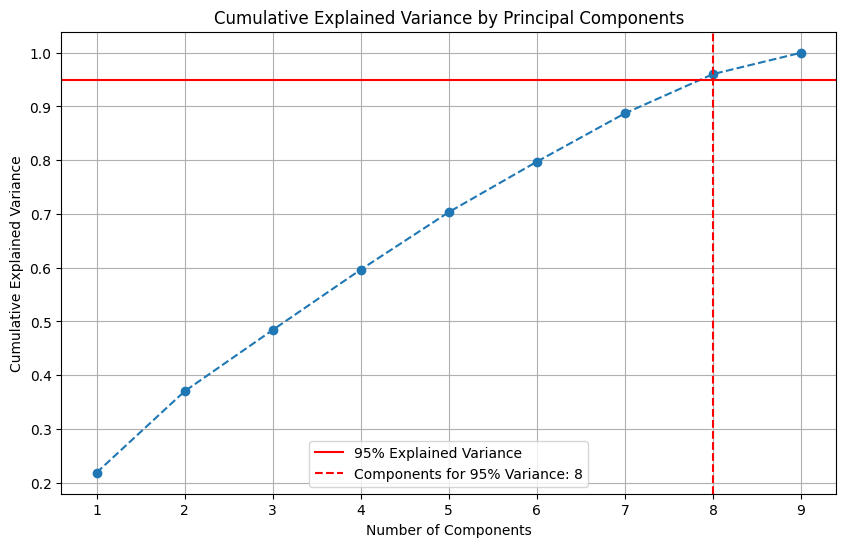

In [70]:
pca = PCA()
pca.fit(df_scaled)

cum_var_exp = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cum_var_exp) + 1), cum_var_exp, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='-', label='95% Explained Variance')
plt.axvline(x=np.argmax(cum_var_exp >= 0.95) + 1, color='r', linestyle='--', label=f'Components for 95% Variance: {np.argmax(cum_var_exp >= 0.95) + 1}')
plt.legend()
plt.show()

Проведя ряд экспериментов, я принял решение обучать модели на датасете сниженной методом UMAP размерности c использованием 8 компонент

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


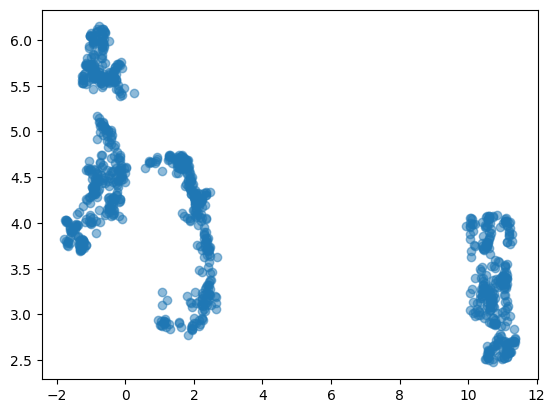

In [71]:
umap_reducer = umap.UMAP(n_components=8, random_state=42)
df_reduced = umap_reducer.fit_transform(df_scaled)
plt.scatter(df_reduced[:, 0], df_reduced[:, 1], alpha=0.5)


# Часть 2. Моделирование.

Постройте три варианта кластеризации: k-means, hierarhical и DBSCAN, подберите оптимальное количество кластеров для каждого метода при помощи Elbow method и Silhouette plot;
Также воспользуйтесь различными вариантами сжатия признакового пространства (PCA, UMAP, tSNE) и визуализируйте результаты кластеризации на двумерной плоскости.


In [72]:
inertia = []
for i in range(1,21):
    kmeans = KMeans(n_clusters=i, random_state=10, n_init=10).fit(df_reduced)
    inertia_i = kmeans.inertia_
    inertia.append(inertia_i)

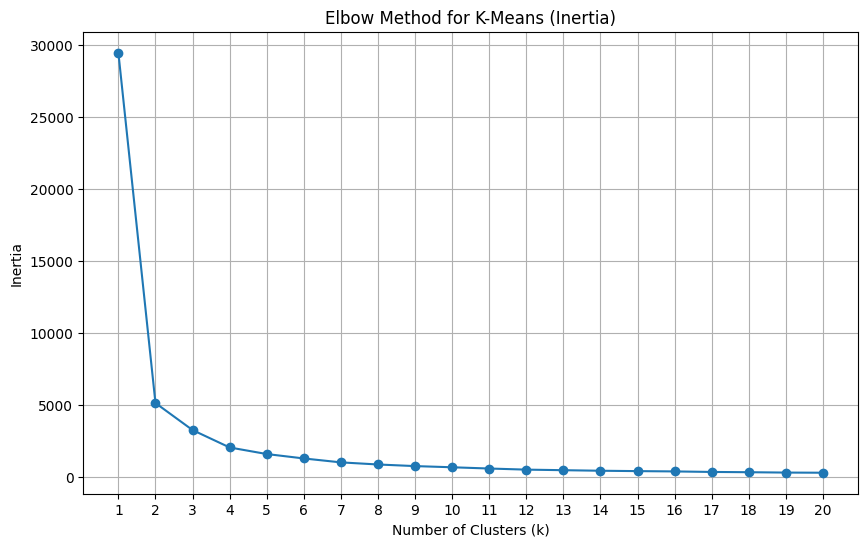

In [73]:
plt.figure(figsize=(10, 6))
plt.plot(range(1,21), inertia, marker='o')
plt.title('Elbow Method for K-Means (Inertia)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.xticks(range(1, 21))
plt.show()

In [74]:
D = []
for i in range(1,19):
    Di = (inertia[i] - inertia[i+1]) / (inertia[i-1] - inertia[i])
    D.append(Di)

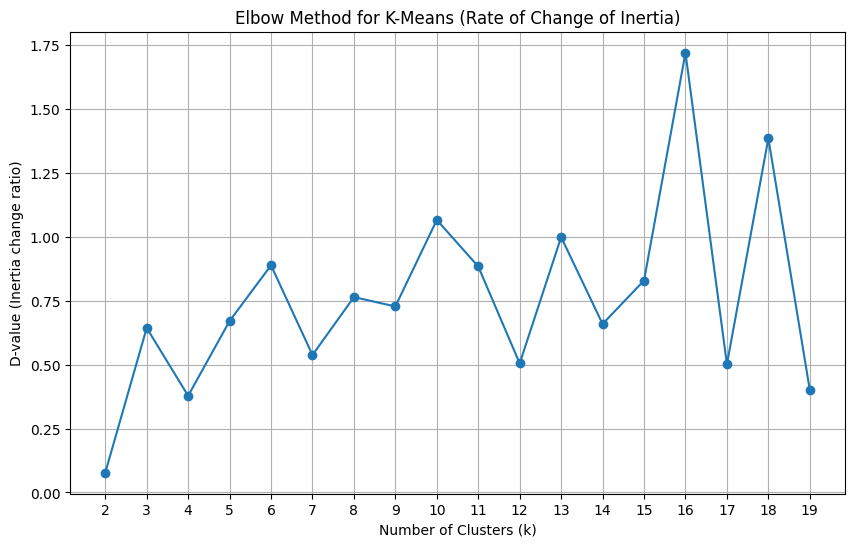

In [75]:
plt.figure(figsize=(10, 6))
plt.plot(range(2,20), D, marker='o');
plt.title('Elbow Method for K-Means (Rate of Change of Inertia)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('D-value (Inertia change ratio)')
plt.grid(True)
plt.xticks(range(2, 20))
plt.show()

Из графиков инерции видно, что хорошие значения приходятся на 4 кластера, такой размер и будем использовать

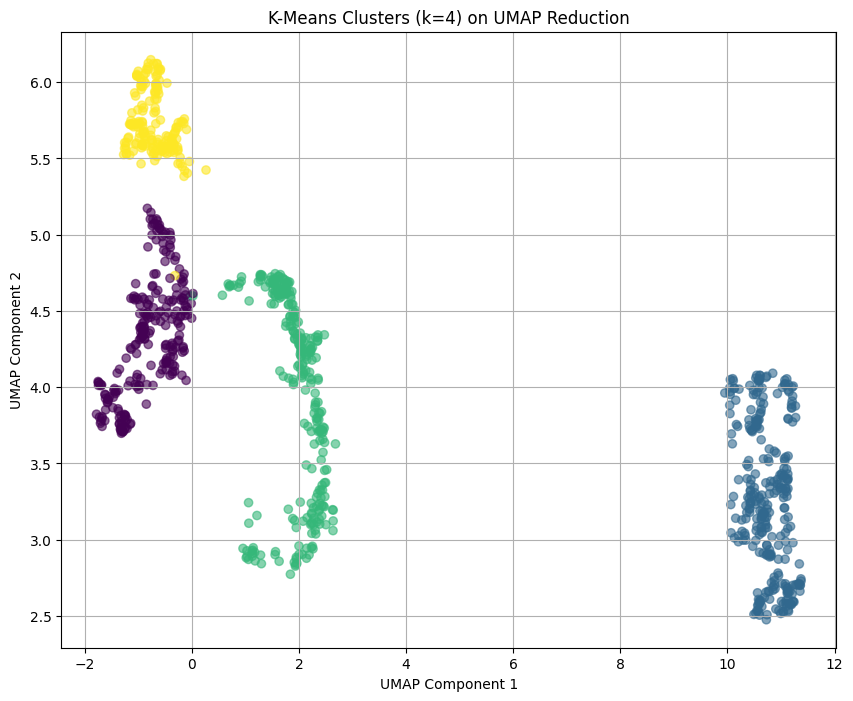

In [76]:
kmeans = KMeans(n_clusters=4, random_state=10, n_init=10).fit(df_reduced)
km_labels = kmeans.labels_
plt.figure(figsize=(10, 8))
plt.scatter(df_reduced[:,0], df_reduced[:,1], c=km_labels, cmap='viridis', alpha=0.6);
plt.title('K-Means Clusters (k=4) on UMAP Reduction')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.grid(True)
plt.show()

**Переходим к методу аггломеративной кластеризации**

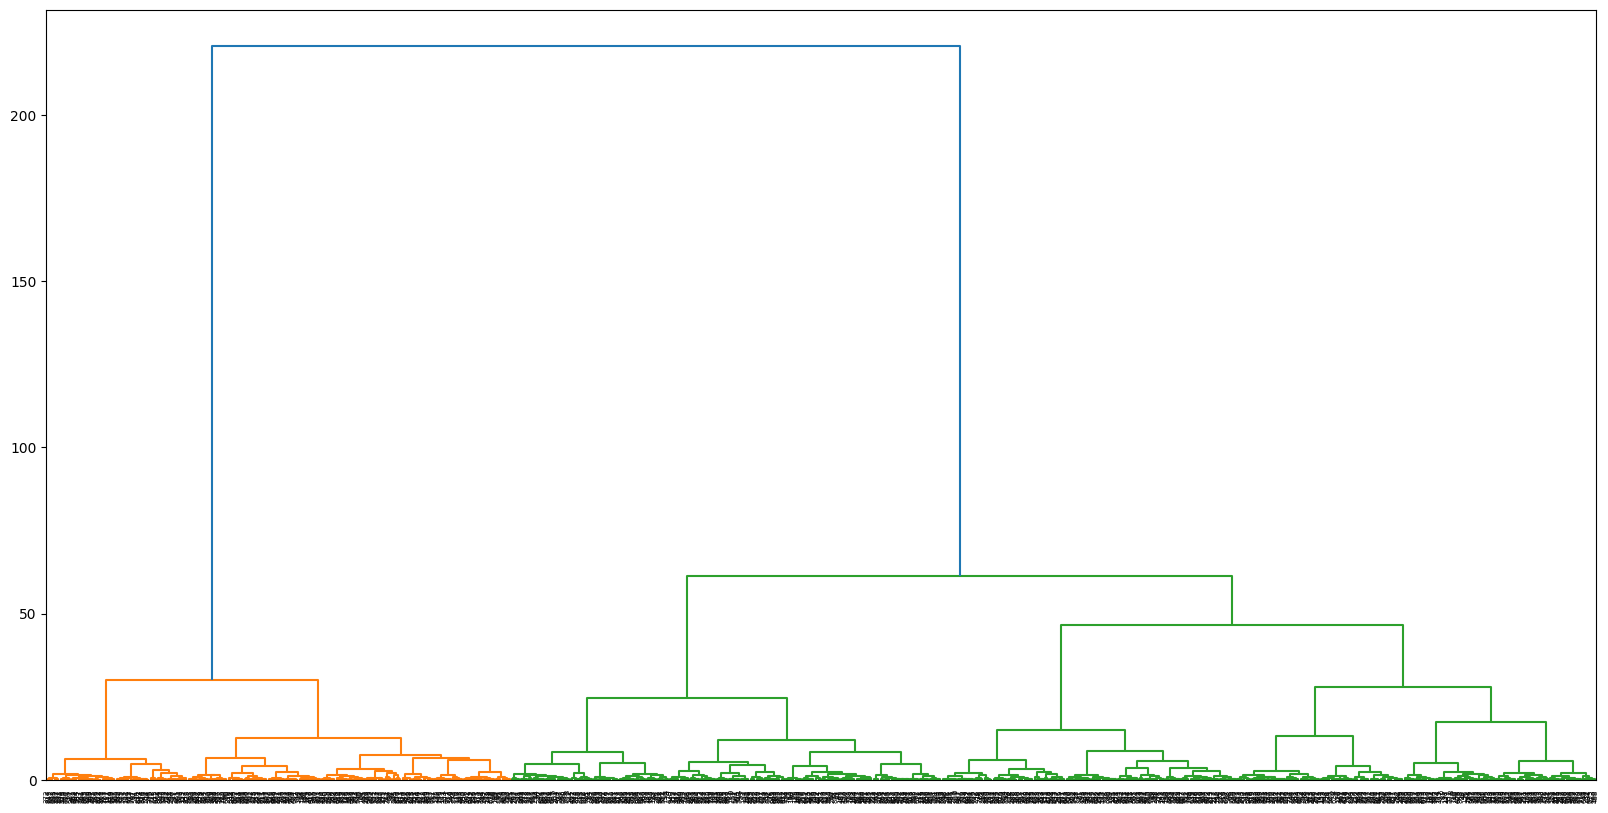

In [77]:
plt.figure(figsize=(20,10))
linkage_ = linkage(df_reduced, method='ward')
dendrogram_ = dendrogram(linkage_)

Подбор числа кластеров сделаем силуэтным способом

In [78]:
silhouette = []
clusters_range = np.arange(2,21)
for i in tqdm(clusters_range):
    agg = AgglomerativeClustering(n_clusters=i).fit(df_reduced)
    labels = agg.labels_
    score = silhouette_score(df_reduced, labels)
    silhouette.append(score)

100%|██████████| 19/19 [00:01<00:00, 14.70it/s]


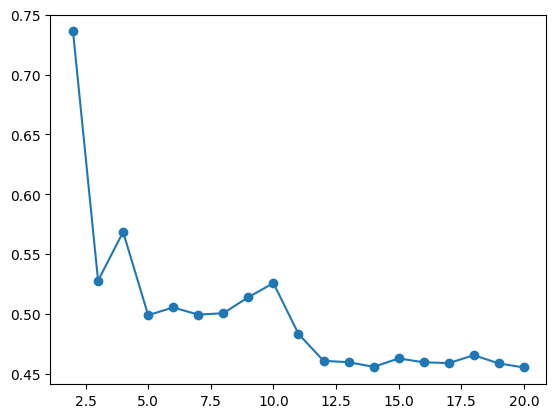

In [79]:
plt.plot(clusters_range, silhouette, marker='o');

Мы видим "полки" в районе 5-8 и 12-20 кластеров.\
 Больше 10 кластеров - это слишком много, поэтому построим skatter plot для значений от 2 до 10.

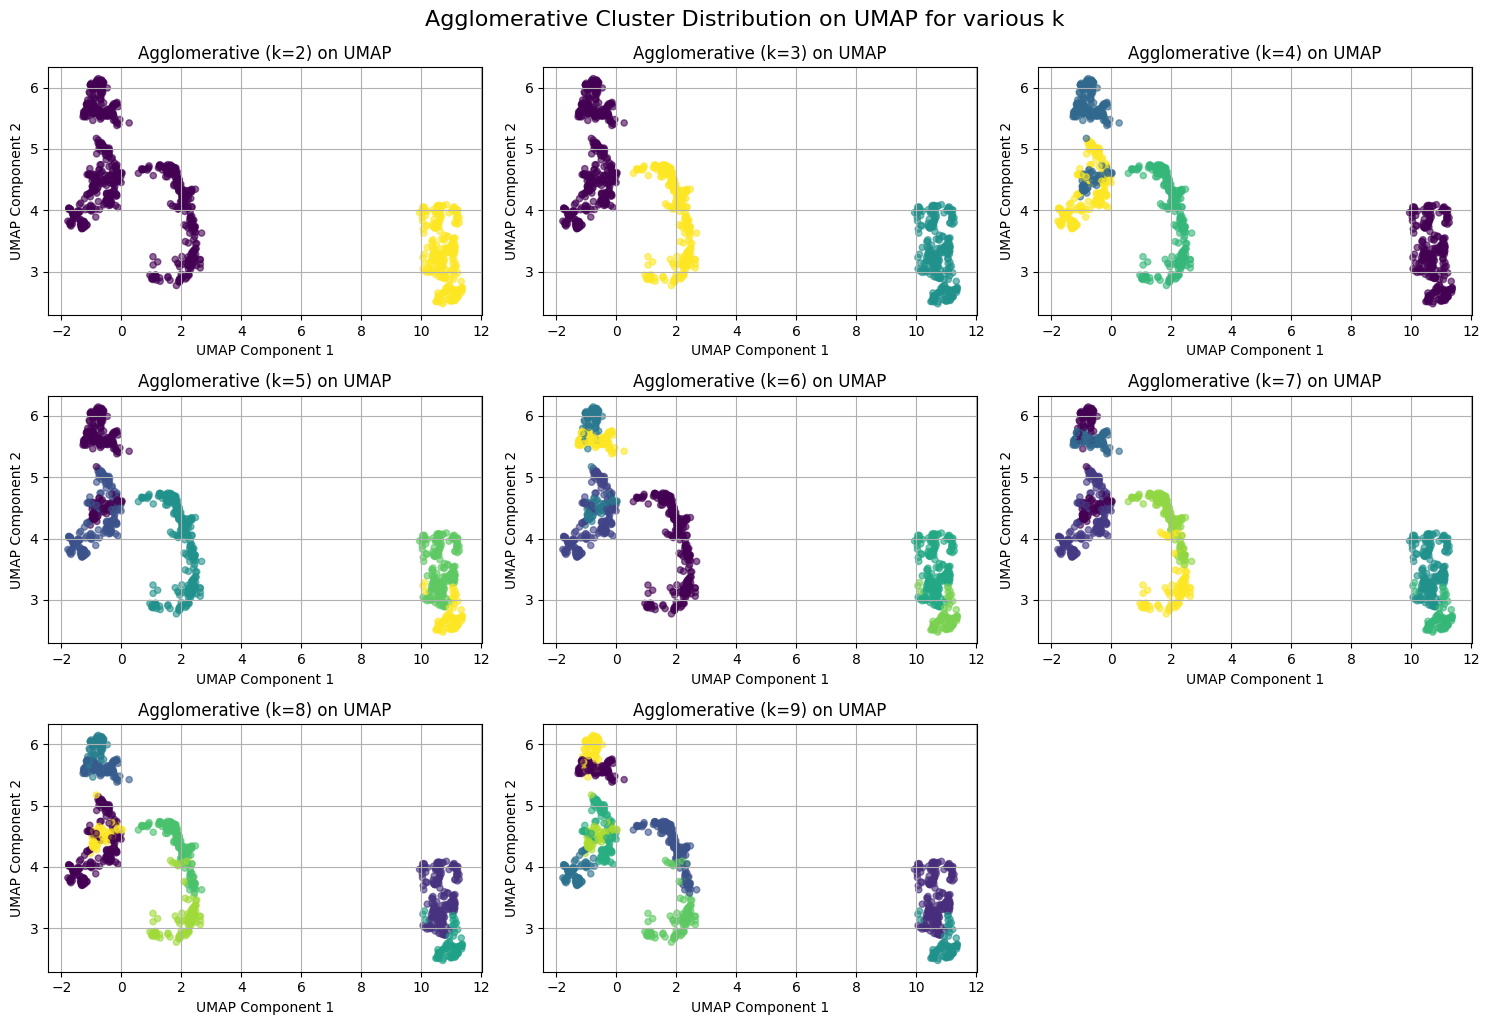

In [80]:
cluster_sizes = range(2, 10, 1)

plt.figure(figsize=(15, 10))

for i, k in enumerate(cluster_sizes):

    agg = AgglomerativeClustering(n_clusters=k).fit(df_reduced)
    labels = agg.labels_

    plt.subplot(3, 3, i + 1)
    plt.scatter(df_reduced[:, 0], df_reduced[:, 1], c=labels, cmap='viridis', alpha=0.6, s=20)
    plt.title(f'Agglomerative (k={k}) on UMAP')
    plt.xlabel('UMAP Component 1')
    plt.ylabel('UMAP Component 2')
    plt.grid(True)

plt.tight_layout()
plt.suptitle('Agglomerative Cluster Distribution on UMAP for various k', y=1.02, fontsize=16)
plt.show()

На основании графика силуэта и визуализаций я принял решение использовать 5 кластеров.

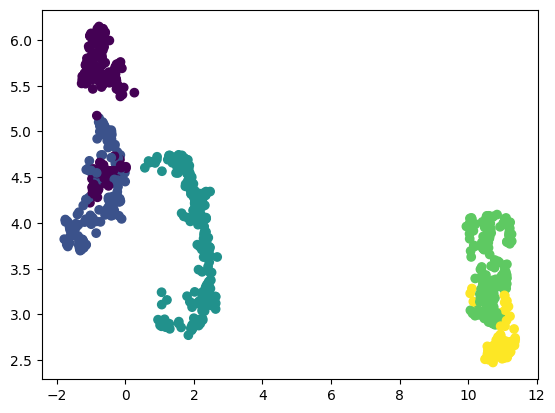

In [81]:
agg = AgglomerativeClustering(n_clusters=5).fit(df_reduced)
agg_labels = agg.labels_

plt.scatter(df_reduced[:,0], df_reduced[:,1], c=agg_labels);

**Перейдем к DB-SCAN**

In [82]:
silhouette = []
clusters = []
eps_range = np.arange(0.1,1.5,0.05)
for i in tqdm(eps_range):
    dbscan = DBSCAN(eps=i).fit(df_reduced)
    labels = dbscan.labels_
    uniq_labels = np.unique(labels)
    n_clusters = len(uniq_labels[uniq_labels != -1])
    if n_clusters > 1:
        score = silhouette_score(df_reduced, labels)
    else:
        score = 0
    silhouette.append(score)
    clusters.append(n_clusters)

100%|██████████| 28/28 [00:02<00:00, 13.33it/s]


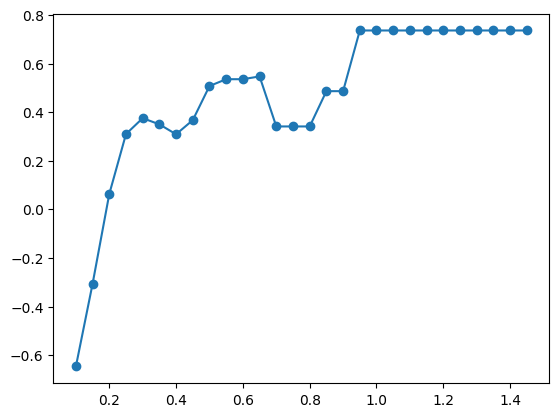

In [83]:
plt.plot(eps_range, silhouette, marker='o');

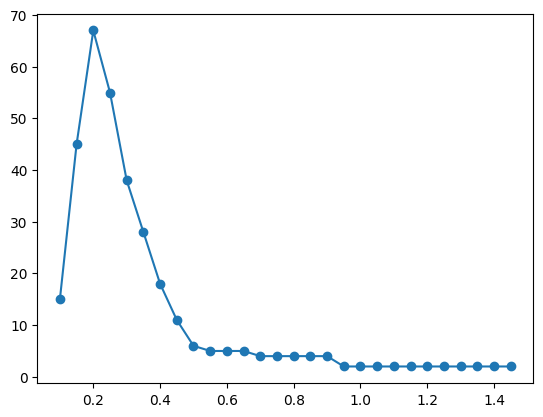

In [84]:
plt.plot(eps_range, clusters, marker='o');

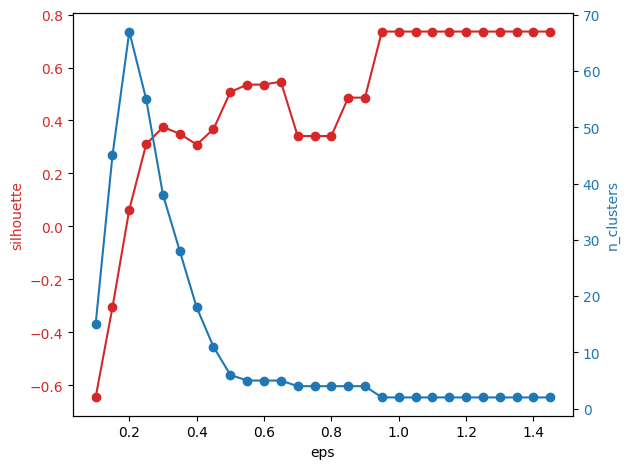

In [85]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.plot(eps_range, silhouette, marker='o', color=color)
ax1.set_xlabel('eps')
ax1.set_ylabel('silhouette', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.plot(eps_range, clusters, marker='o', color=color)
ax2.set_ylabel('n_clusters', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

Можно увидеть 2 зоны с ровными полками в районе 5-6 и 2 кластеров, подберем значение eps чтобы делить на 6 кластеров, один из которых будет выбросами

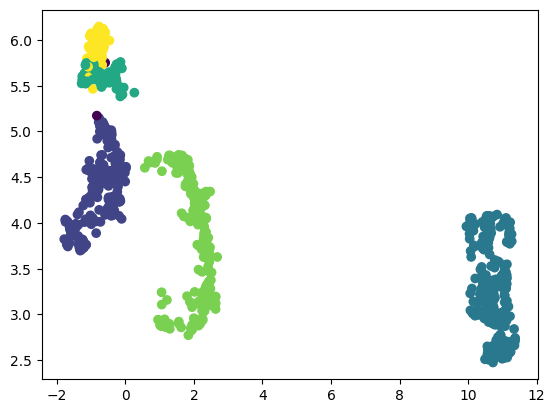

In [86]:
dbscan = DBSCAN(eps=0.65).fit(df_reduced)
DB_labels = dbscan.labels_

plt.scatter(df_reduced[:,0], df_reduced[:,1], c=DB_labels);

In [87]:
np.unique(DB_labels)

array([-1,  0,  1,  2,  3,  4])

In [88]:
uniq_labels = np.unique(DB_labels)
uniq_labels

array([-1,  0,  1,  2,  3,  4])

In [89]:
n_clusters = len(uniq_labels[uniq_labels != -1])
n_clusters

5

In [90]:
uniq_labels = np.unique(DB_labels)
print(uniq_labels)

n_clusters = len(uniq_labels[uniq_labels != -1])
print(n_clusters)

[-1  0  1  2  3  4]
5


(array([  2.,   0., 248.,   0., 300.,   0., 108.,   0., 278.,  64.]),
 array([-1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ]),
 <BarContainer object of 10 artists>)

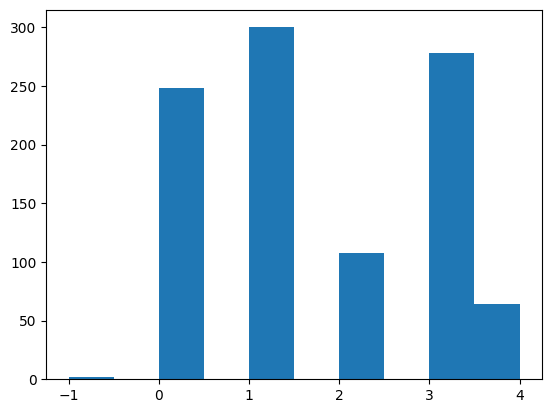

In [91]:
plt.hist(DB_labels)


# Часть 3. Интерпретация.

Теперь ваша задача - попытаться проинтерпретировать получившиеся кластеры, начните с простого расчета средних значений признаков для каждого из кластеров, есть ли интересные закономерности?
Теперь постройте boxplot-ы для каждого признака, сгруппировав значения по кластерам, по каким признакам заметно наибольшее отличие кластеров друг от друга? Можно ли их интерпретировать?

Для разнообразия визуализацию в этой части будем делать не на UMAP, а на T-SNE

**Для начала проанализируем распределение кластеров с использованием K-means**

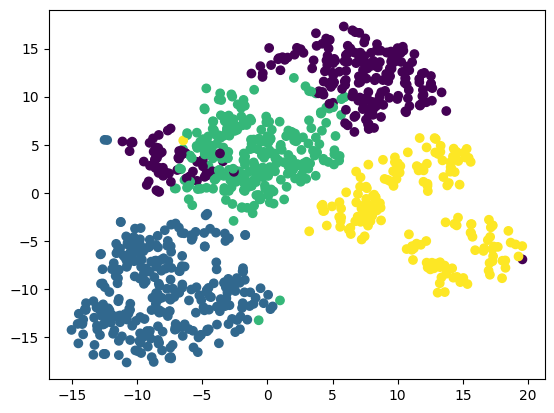

In [92]:
plt.scatter(df_tsne[:,0], df_tsne[:,1], c=km_labels);

In [93]:
df['labels'] = km_labels
df['labels'].value_counts(normalize=True)

,proportion
labels,
1,0.300
2,0.280
0,0.246
3,0.174


Метки классов распределены достаточно равномерно, на визуализации выглядит тоже очень прилично

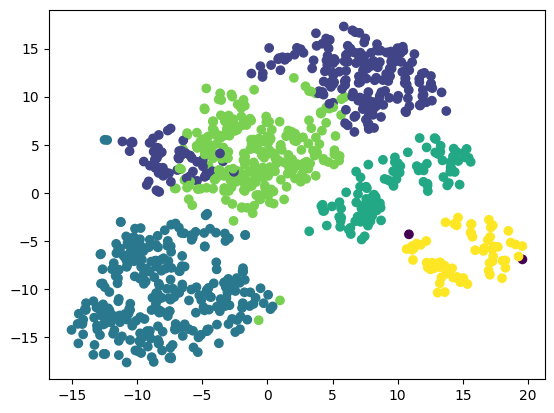

In [94]:
plt.scatter(df_tsne[:,0], df_tsne[:,1], c=DB_labels);

In [95]:
df['labels'] = DB_labels
df['labels'].value_counts(normalize=True)

,proportion
labels,
1,0.300
3,0.278
0,0.248
2,0.108
4,0.064
-1,0.002


DB-SCAN в целом тоже дает красивый график и относительно равномерные классы, при этом выделяя 2 точки, которые являются выбросами

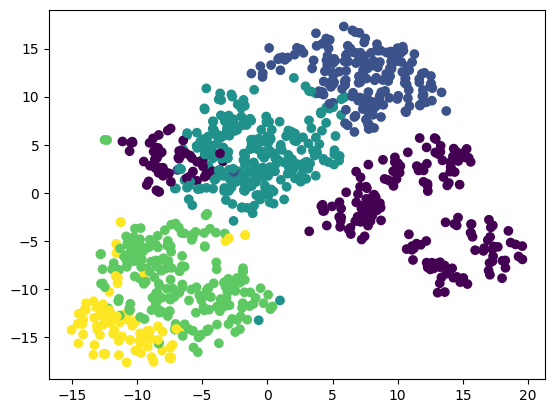

In [96]:
plt.scatter(df_tsne[:,0], df_tsne[:,1], c=agg_labels);

In [97]:
df['labels'] = agg_labels
df['labels'].value_counts(normalize=True)

,proportion
labels,
2,0.278
0,0.232
3,0.209
1,0.190
4,0.091


Аггломеративный метод равномерно распределяет метки классов, однако на визуализации кажется, что они несколько смешиваются в отдельных областях

Далее построим "ящики с усами" и гистограммы для разных моделей и постараемся выделить закономерности

In [98]:
df['labels'] = km_labels

numerical_cols_original = df.select_dtypes(include=['int64', 'float64']).columns.drop(['Unnamed: 0', 'labels'], errors='ignore')
categorical_cols_original = df.select_dtypes(include='object').columns

median_numerical = df.groupby('labels')[numerical_cols_original].median().round(2)

mode_categorical = df.groupby('labels')[categorical_cols_original].agg(lambda x: x.mode()[0])

cluster_summary = pd.concat([median_numerical, mode_categorical], axis=1)

print("Cluster Summary (Medians for numerical, Modes for categorical):")
print(cluster_summary.T)

Cluster Summary (Medians for numerical, Modes for categorical):
labels                   0       1         2       3
Age                   34.0    28.0      36.0    35.0
Job                    2.0     2.0       2.0     1.0
Credit amount       2386.0  1887.5    3561.0  1767.0
Duration              18.0    18.0      24.0    12.0
Sex                   male  female      male    male
Housing                own     own       own     own
Saving accounts     little  little    little  little
Checking account    little  little  moderate  little
Purpose           radio/TV     car       car     car


/tmp/ipython-input-4003292369.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=col, y='labels', orient='h', palette='viridis')


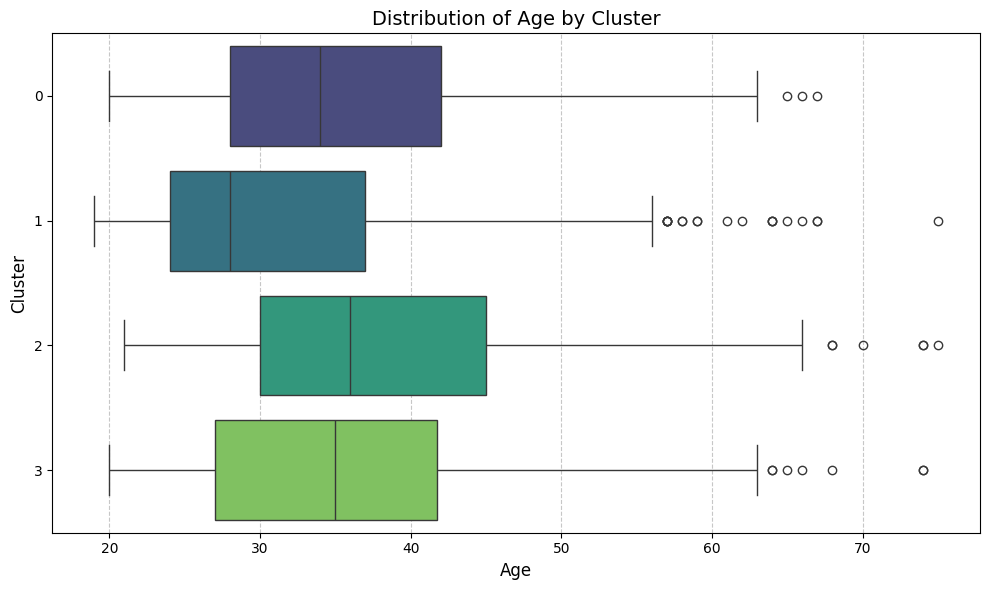

/tmp/ipython-input-4003292369.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=col, y='labels', orient='h', palette='viridis')


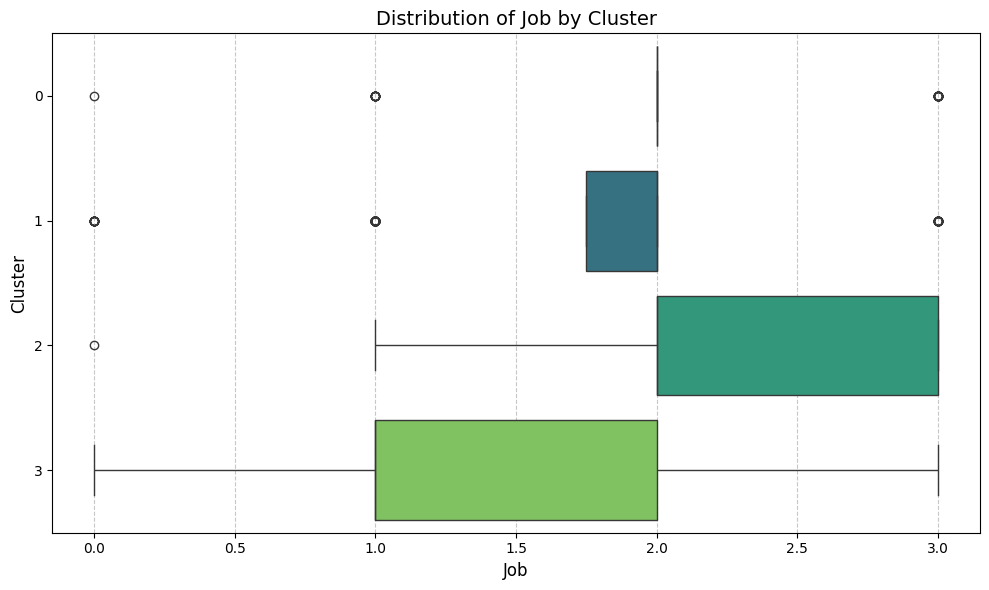

/tmp/ipython-input-4003292369.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=col, y='labels', orient='h', palette='viridis')


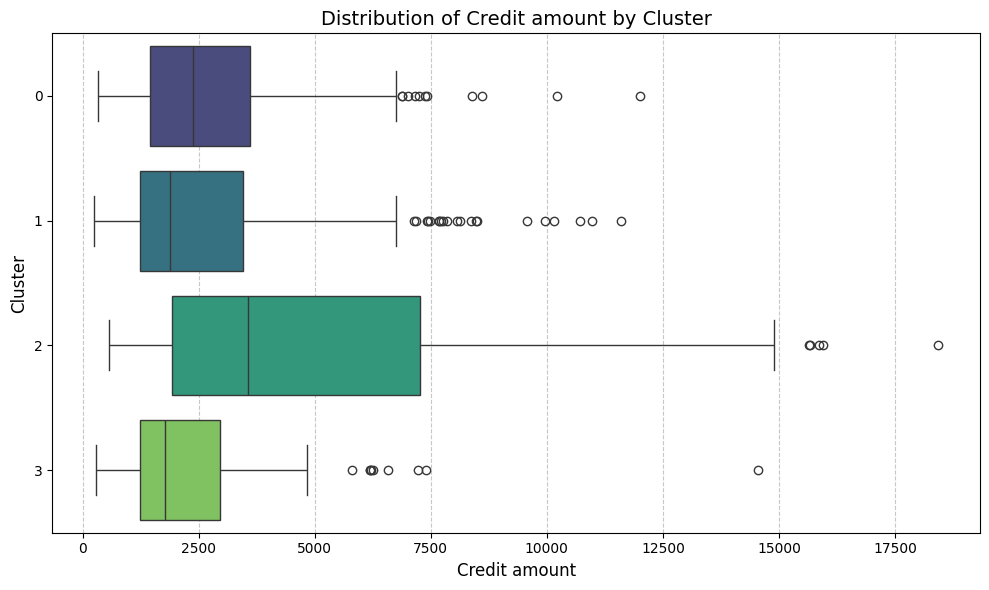

/tmp/ipython-input-4003292369.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=col, y='labels', orient='h', palette='viridis')


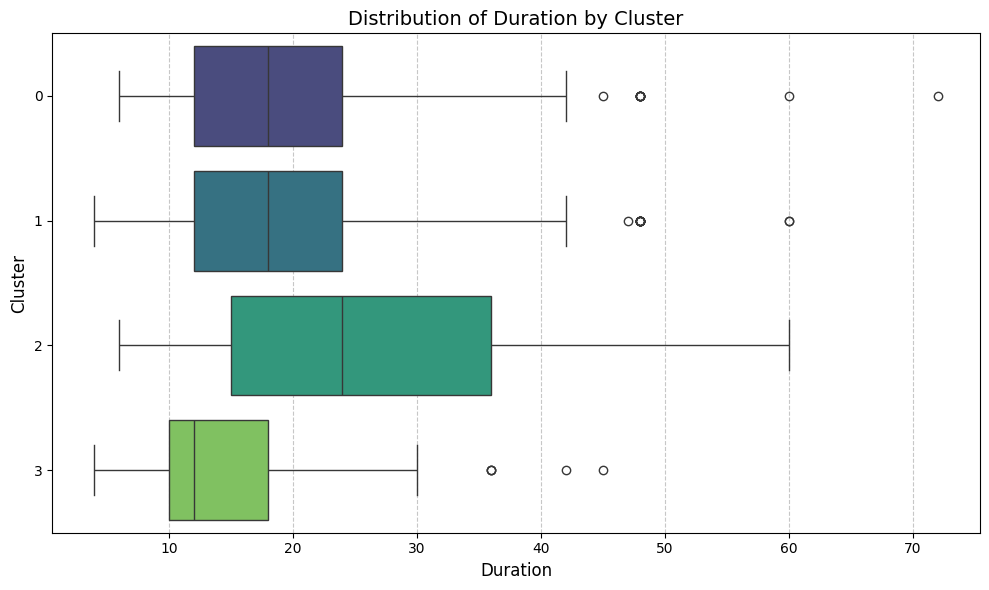

In [99]:
for col in numerical_cols_original:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x=col, y='labels', orient='h', palette='viridis')
    plt.title(f'Distribution of {col} by Cluster', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Cluster', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

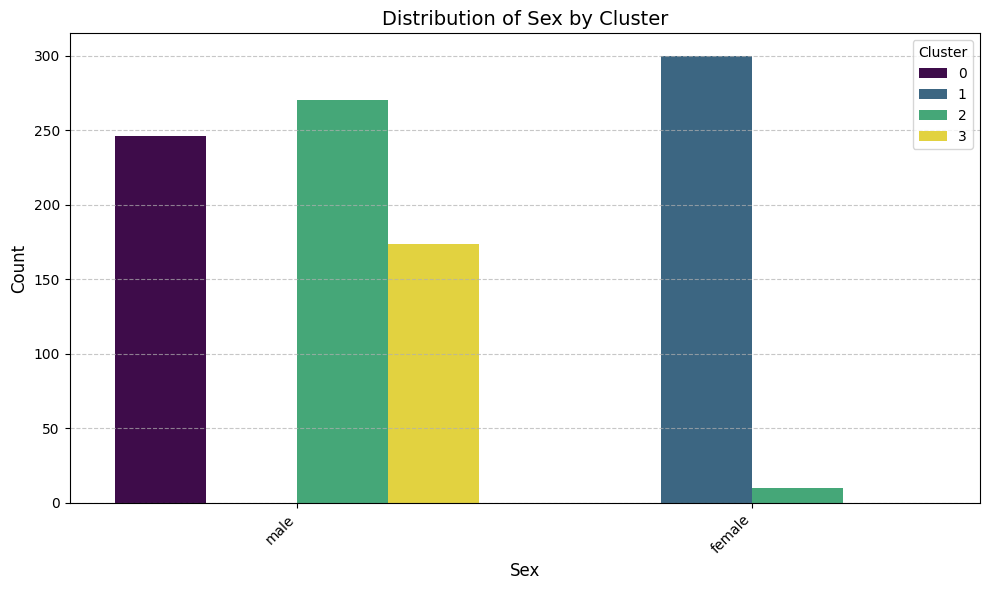

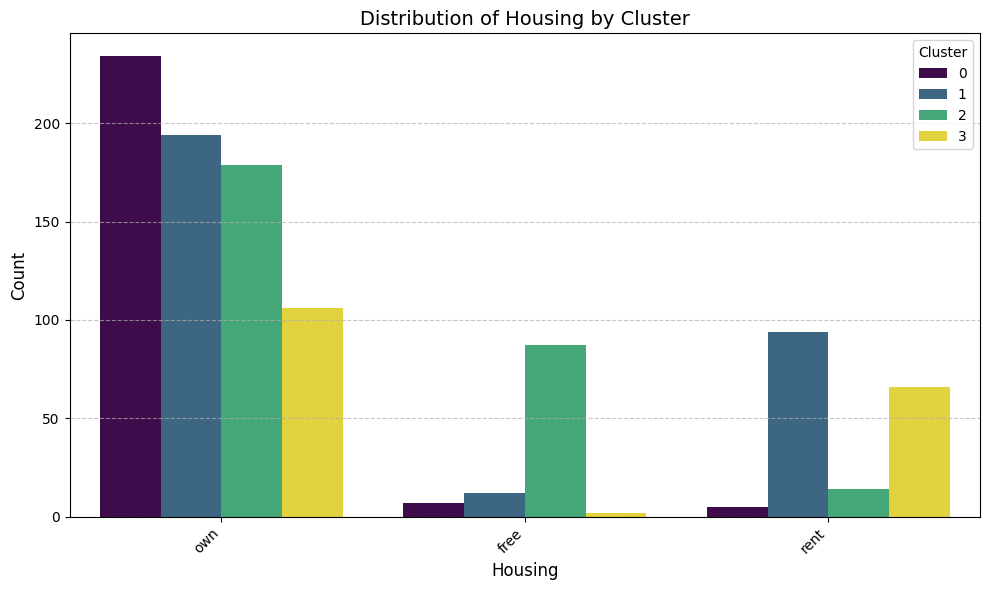

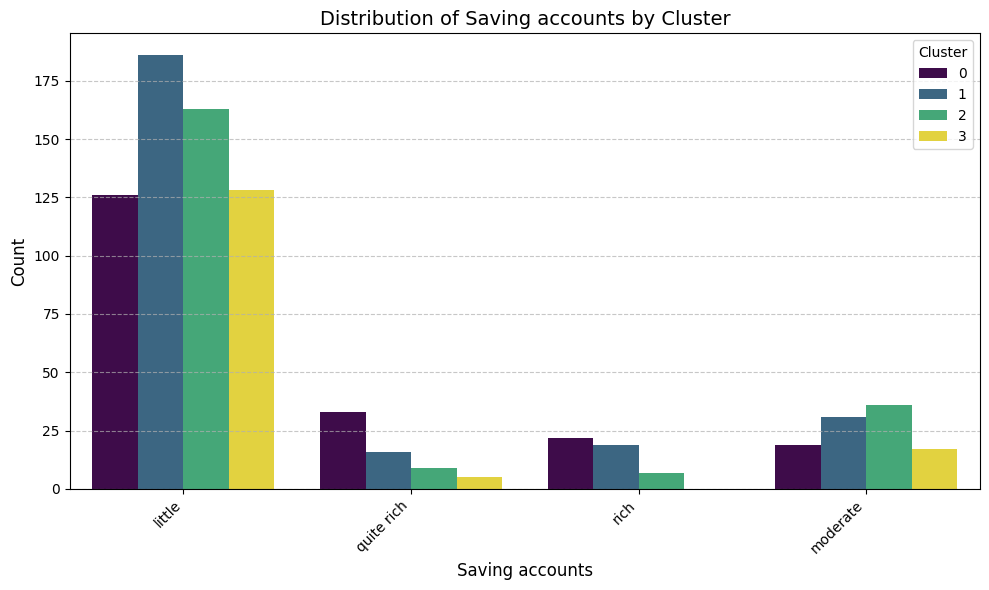

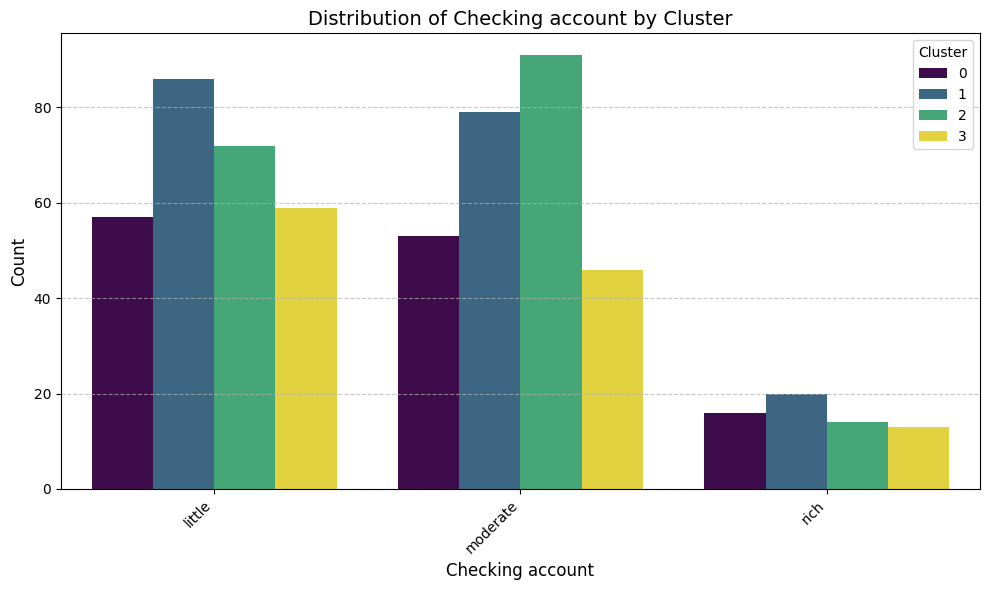

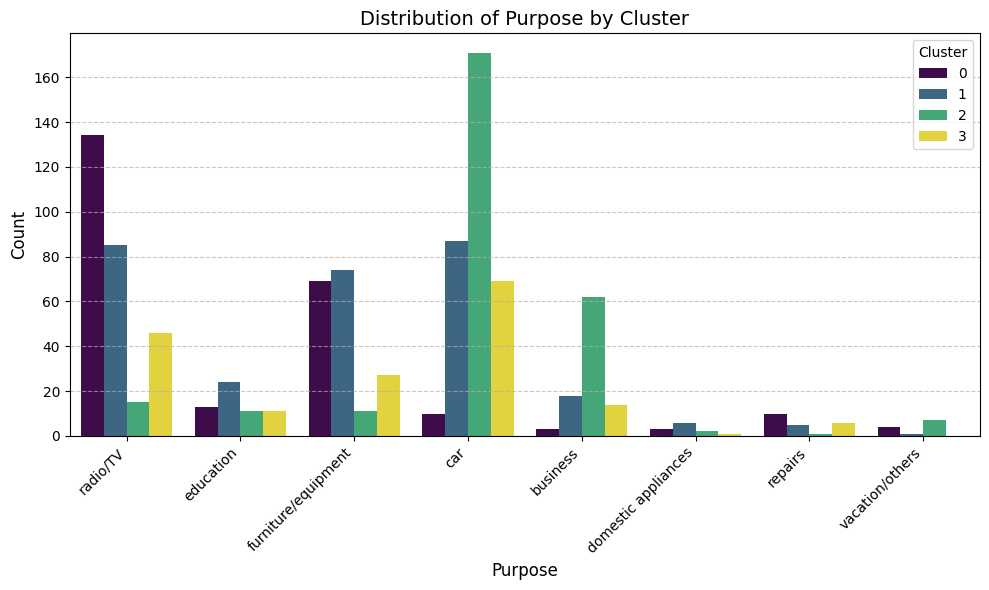

In [100]:
for col in categorical_cols_original:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=col, hue='labels', palette='viridis')
    plt.title(f'Distribution of {col} by Cluster', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.legend(title='Cluster')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [101]:
df['labels'] = DB_labels

numerical_cols_original = df.select_dtypes(include=['int64', 'float64']).columns.drop(['Unnamed: 0', 'labels'], errors='ignore')
categorical_cols_original = df.select_dtypes(include='object').columns

median_numerical = df.groupby('labels')[numerical_cols_original].median().round(2)

mode_categorical = df.groupby('labels')[categorical_cols_original].agg(lambda x: x.mode()[0])

cluster_summary = pd.concat([median_numerical, mode_categorical], axis=1)

print("Cluster Summary (Medians for numerical, Modes for categorical):")
print(cluster_summary.T)

Cluster Summary (Medians for numerical, Modes for categorical):
labels                    -1         0       1       2         3       4
Age                     41.0      34.0    28.0    37.0      36.0    30.0
Job                      1.5       2.0     2.0     1.0       2.0     2.0
Credit amount         2238.5    2386.0  1887.5  1527.0    3609.0  2115.0
Duration                15.0      19.0    18.0    12.0      24.0    12.0
Sex                     male      male  female    male      male    male
Housing                 rent       own     own     own       own    rent
Saving accounts   quite rich    little  little  little    little  little
Checking account    moderate    little  little  little  moderate  little
Purpose             business  radio/TV     car     car       car     car


/tmp/ipython-input-4003292369.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=col, y='labels', orient='h', palette='viridis')


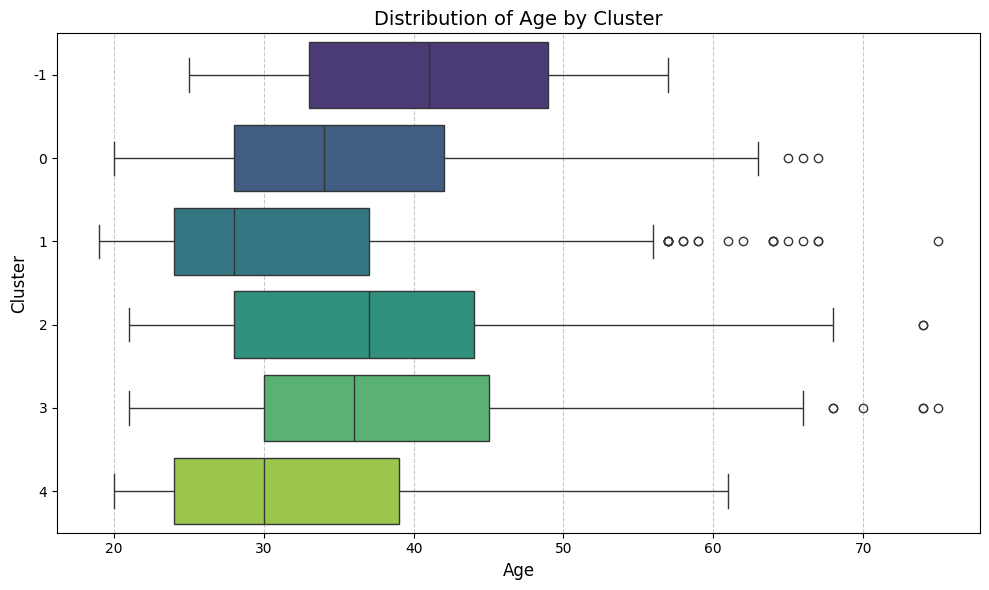

/tmp/ipython-input-4003292369.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=col, y='labels', orient='h', palette='viridis')


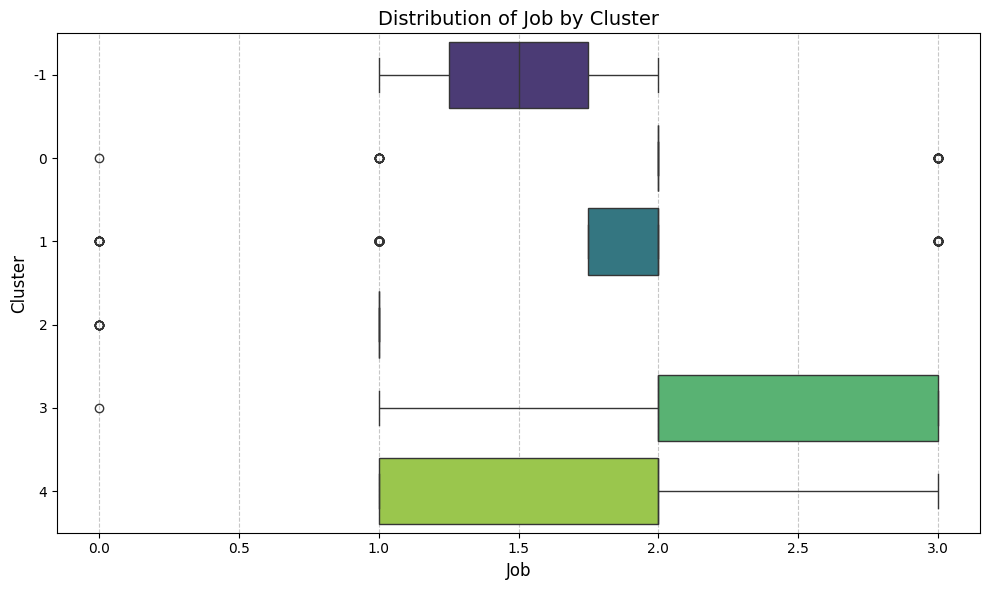

/tmp/ipython-input-4003292369.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=col, y='labels', orient='h', palette='viridis')


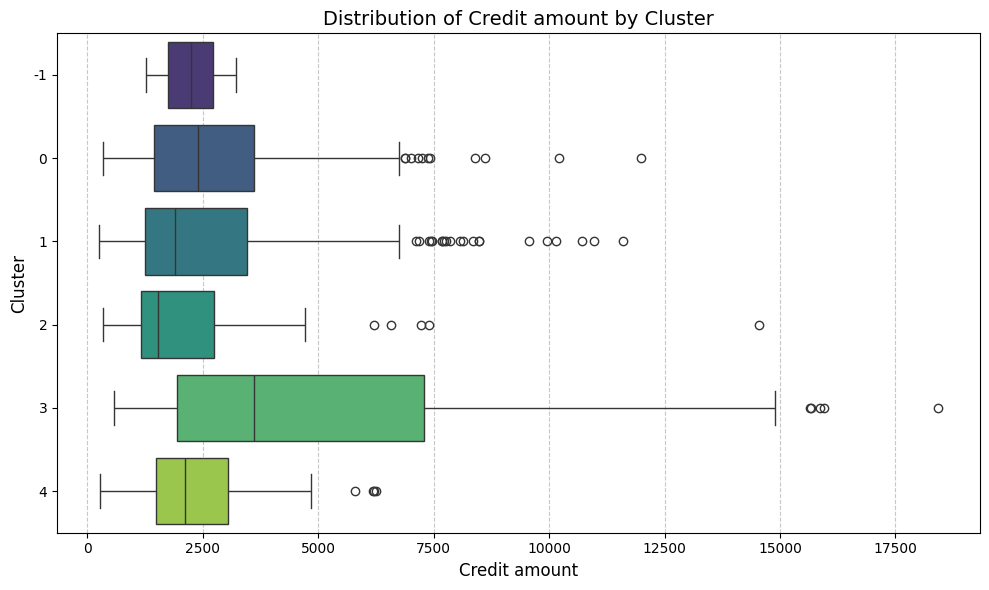

/tmp/ipython-input-4003292369.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=col, y='labels', orient='h', palette='viridis')


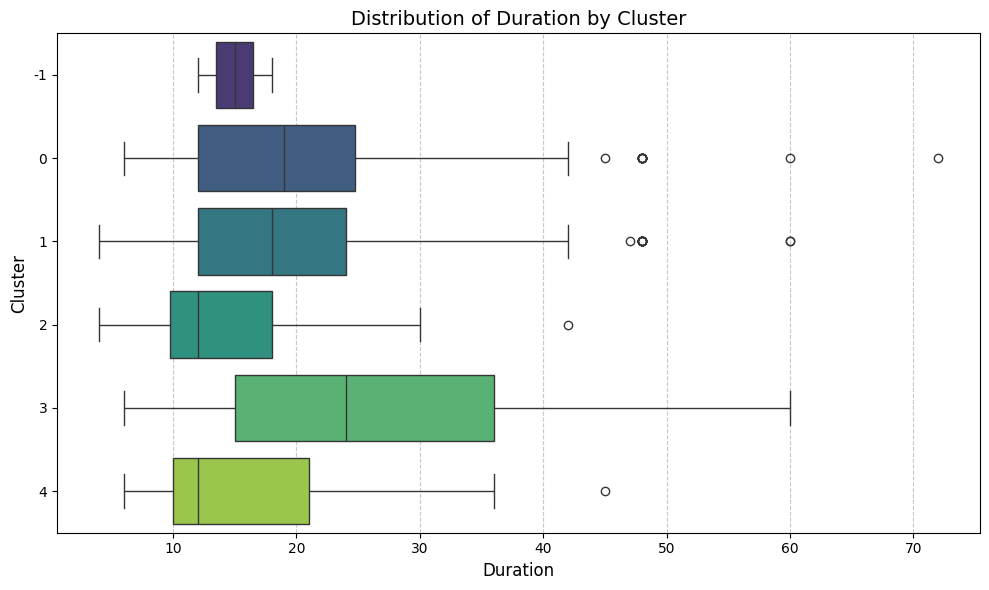

In [102]:
for col in numerical_cols_original:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x=col, y='labels', orient='h', palette='viridis')
    plt.title(f'Distribution of {col} by Cluster', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Cluster', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

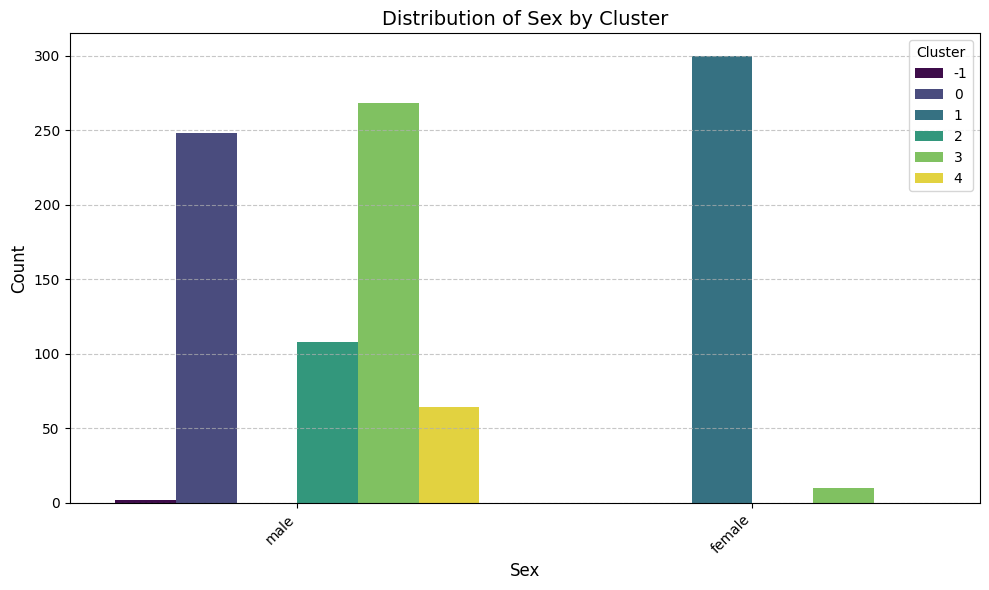

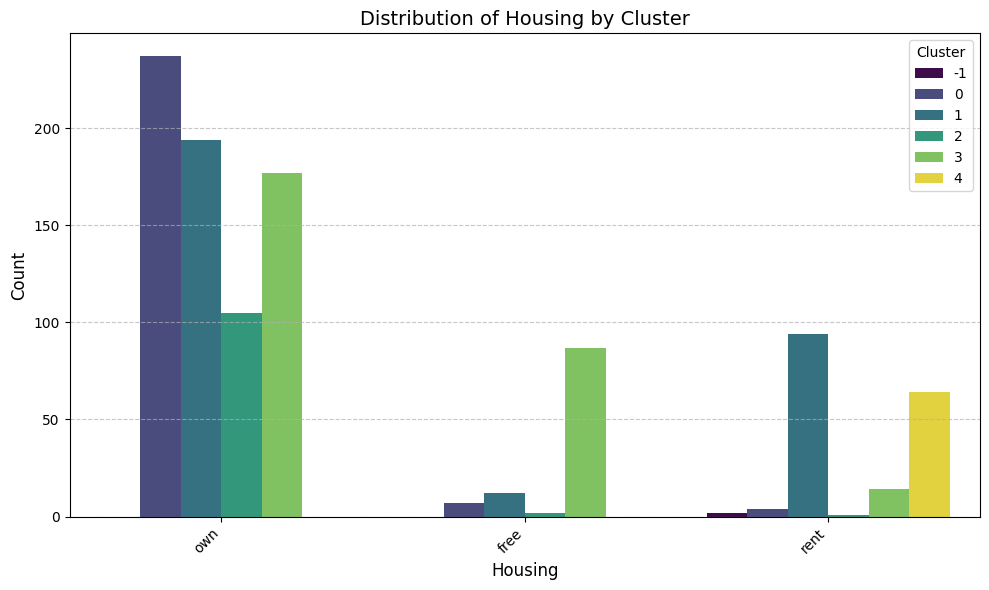

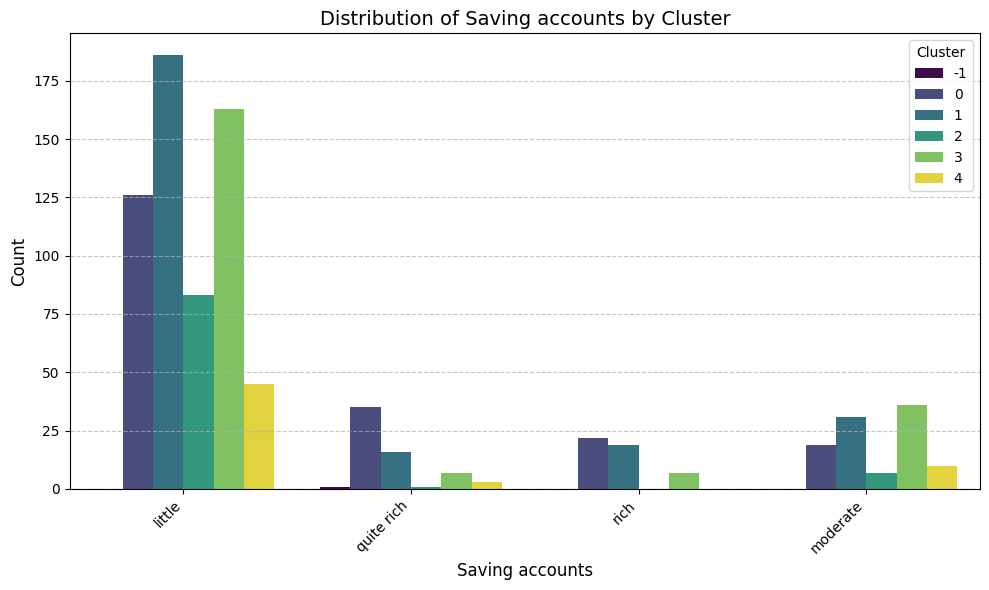

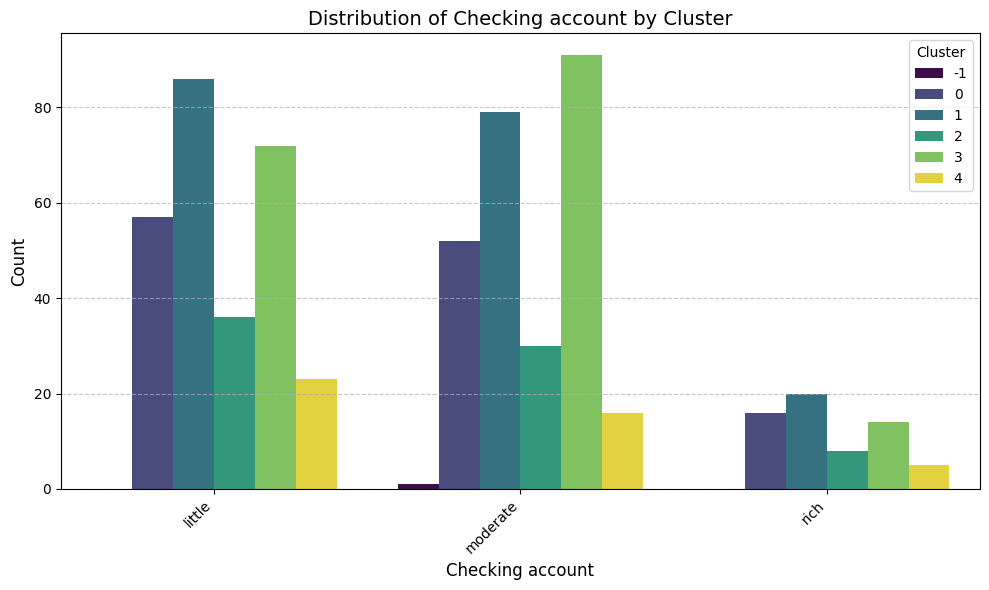

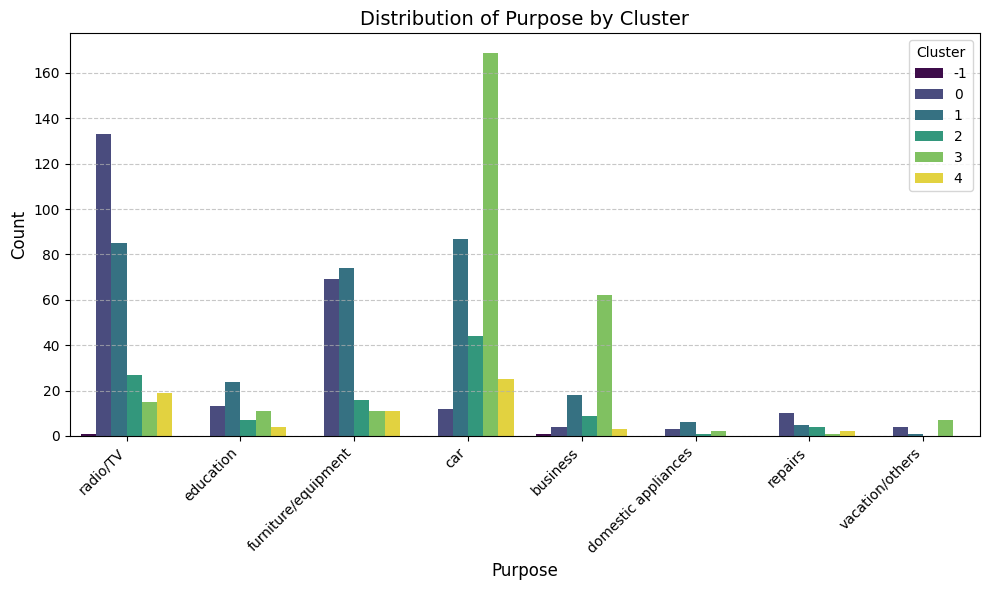

In [103]:
for col in categorical_cols_original:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=col, hue='labels', palette='viridis')
    plt.title(f'Distribution of {col} by Cluster', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.legend(title='Cluster')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=45, ha='right') # Rotate labels for better readability if categories are long
    plt.tight_layout()
    plt.show()

In [104]:
df['labels'] = agg_labels

numerical_cols_original = df.select_dtypes(include=['int64', 'float64']).columns.drop(['Unnamed: 0', 'labels'], errors='ignore')
categorical_cols_original = df.select_dtypes(include='object').columns

median_numerical = df.groupby('labels')[numerical_cols_original].median().round(2)

mode_categorical = df.groupby('labels')[categorical_cols_original].agg(lambda x: x.mode()[0])

cluster_summary = pd.concat([median_numerical, mode_categorical], axis=1)

print("Cluster Summary (Medians for numerical, Modes for categorical):")
print(cluster_summary.T)

Cluster Summary (Medians for numerical, Modes for categorical):
labels                 0         1         2         3                    4
Age                 35.0      33.0      36.0      30.0                 24.0
Job                  1.0       2.0       2.0       2.0                  2.0
Credit amount     1920.5    2382.5    3609.0    1835.0               2124.0
Duration            12.0      20.5      24.0      18.0                 18.0
Sex                 male      male      male    female               female
Housing              own       own       own       own                 rent
Saving accounts   little    little    little    little               little
Checking account  little    little  moderate  moderate               little
Purpose              car  radio/TV       car  radio/TV  furniture/equipment


/tmp/ipython-input-4003292369.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=col, y='labels', orient='h', palette='viridis')


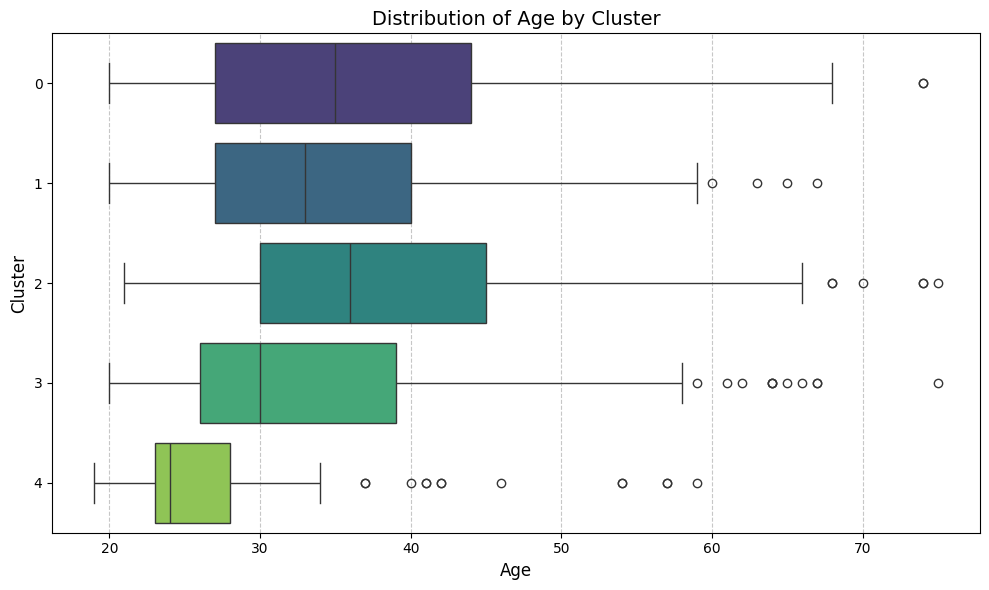

/tmp/ipython-input-4003292369.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=col, y='labels', orient='h', palette='viridis')


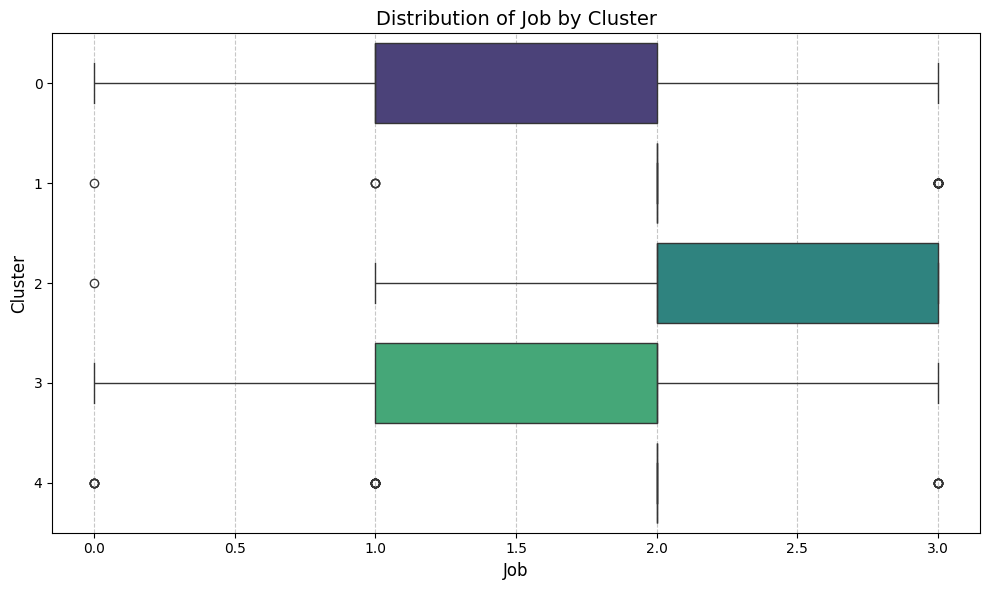

/tmp/ipython-input-4003292369.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=col, y='labels', orient='h', palette='viridis')


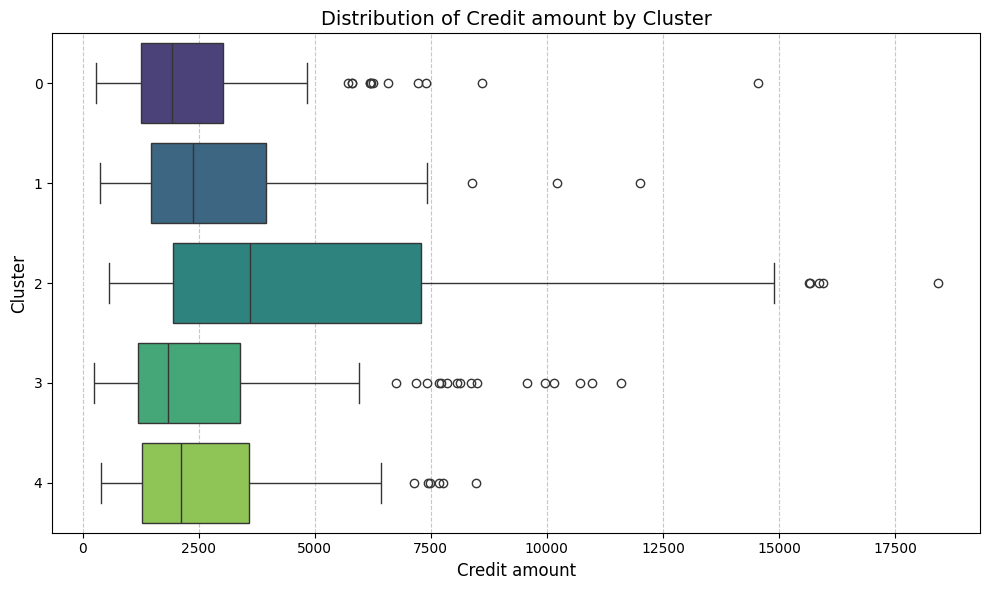

/tmp/ipython-input-4003292369.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=col, y='labels', orient='h', palette='viridis')


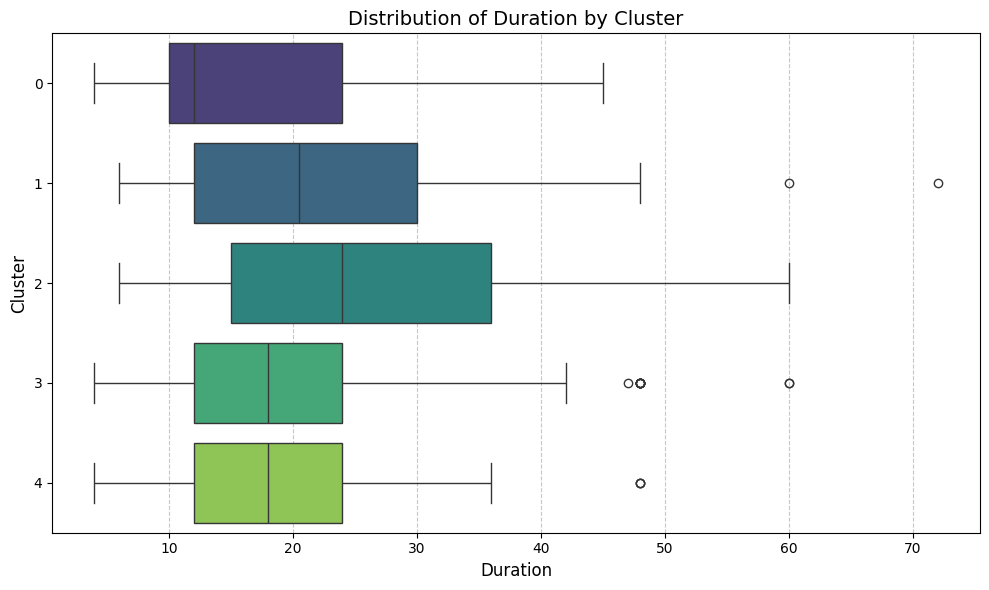

In [105]:
for col in numerical_cols_original:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x=col, y='labels', orient='h', palette='viridis')
    plt.title(f'Distribution of {col} by Cluster', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Cluster', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

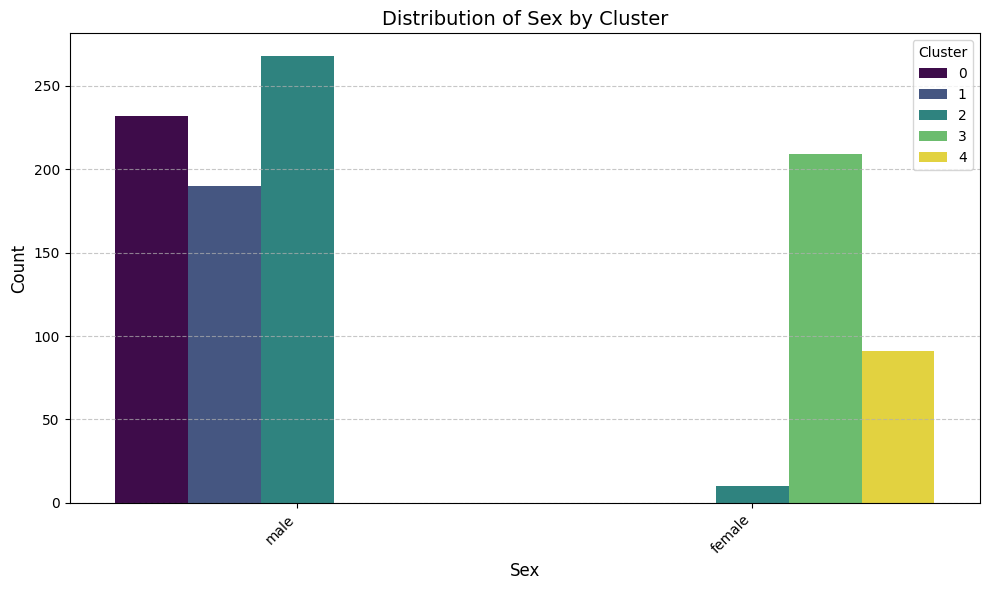

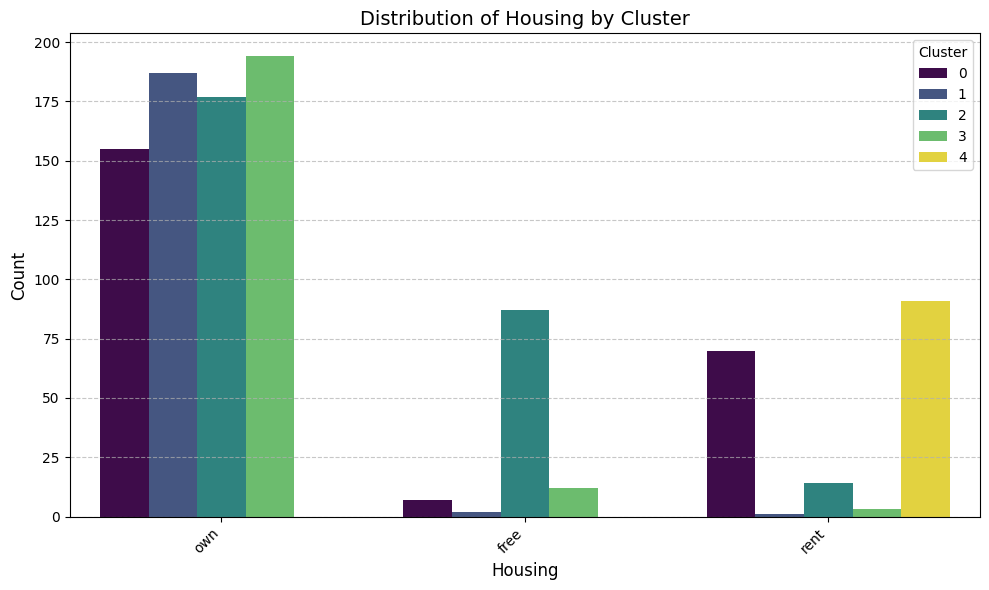

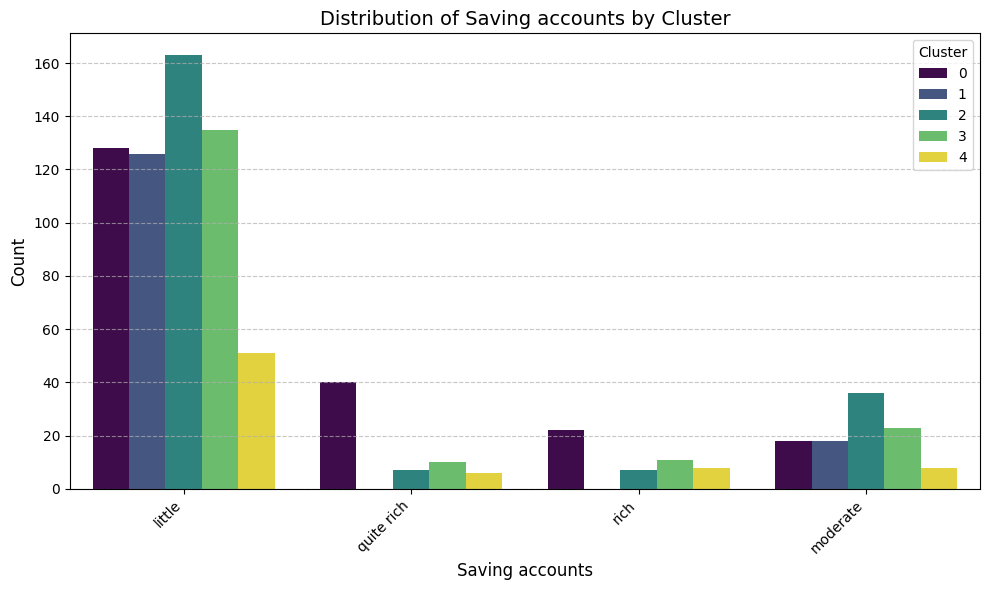

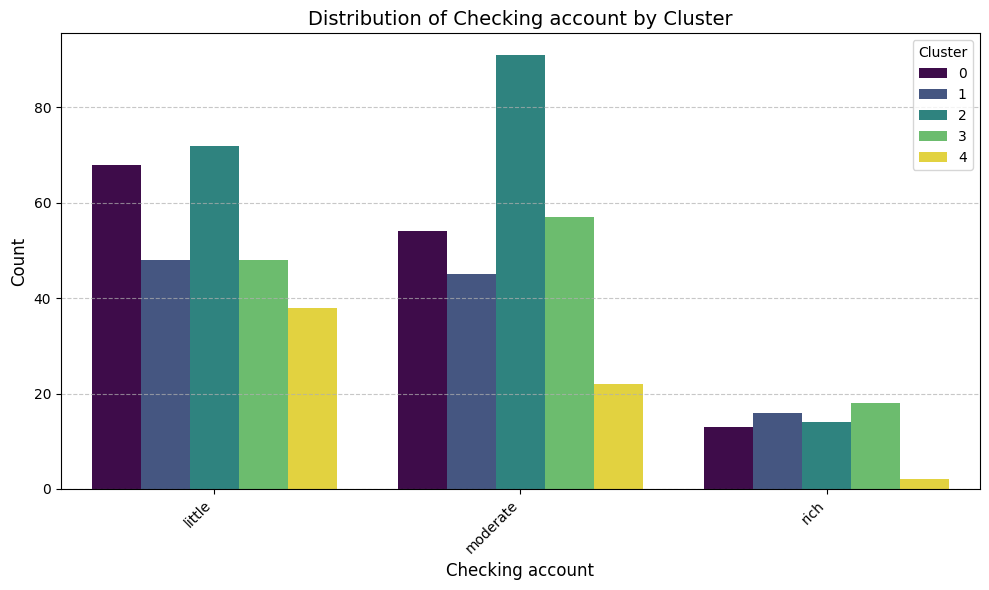

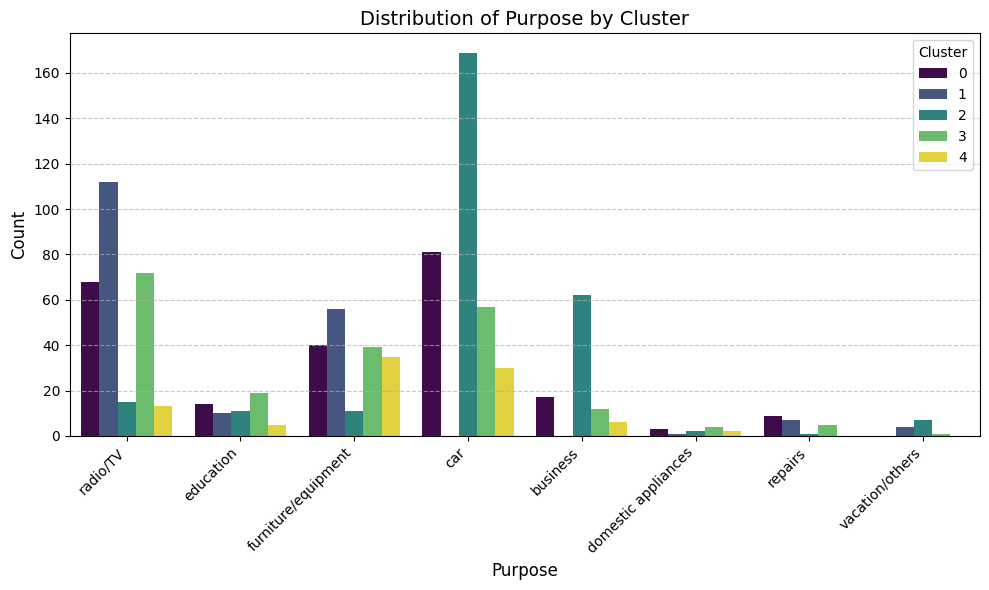

In [106]:
for col in categorical_cols_original:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=col, hue='labels', palette='viridis')
    plt.title(f'Distribution of {col} by Cluster', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.legend(title='Cluster')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=45, ha='right') # Rotate labels for better readability if categories are long
    plt.tight_layout()
    plt.show()

После построения графиков уже можно проследить некоторые закономерности в распределении классов, однако для более релевантных результатов проверим, насколько распределения у разных моделей согласуются между собой

In [107]:
df['kmeans_labels'] = km_labels
df['dbscan_labels'] = DB_labels
df['agglomerative_labels'] = agg_labels

print(df.head())

   Unnamed: 0  Age     Sex  Job Housing Saving accounts Checking account  \
0           0   67    male    2     own             NaN           little   
1           1   22  female    2     own          little         moderate   
2           2   49    male    1     own          little              NaN   
3           3   45    male    2    free          little           little   
4           4   53    male    2    free          little           little   

   Credit amount  Duration              Purpose  labels  kmeans_labels  \
0           1169         6             radio/TV       1              0   
1           5951        48             radio/TV       3              1   
2           2096        12            education       0              3   
3           7882        42  furniture/equipment       2              2   
4           4870        24                  car       2              2   

   dbscan_labels  agglomerative_labels  
0              0                     1  
1              1

Построим матрицы пересечений классов у разных моделей

In [108]:
print("Cross-Tabulation: K-Means vs. DBSCAN")
print(pd.crosstab(df['kmeans_labels'], df['dbscan_labels']))

print("\n Cross-Tabulation: K-Means vs. Agglomerative")
print(pd.crosstab(df['kmeans_labels'], df['agglomerative_labels']))

print("\n Cross-Tabulation: DBSCAN vs. Agglomerative")
print(pd.crosstab(df['dbscan_labels'], df['agglomerative_labels']))

Cross-Tabulation: K-Means vs. DBSCAN
dbscan_labels  -1    0    1    2    3   4
kmeans_labels                            
0               1  245    0    0    0   0
1               0    0  300    0    0   0
2               0    2    0    0  278   0
3               1    1    0  108    0  64

 Cross-Tabulation: K-Means vs. Agglomerative
agglomerative_labels    0    1    2    3   4
kmeans_labels                               
0                      56  190    0    0   0
1                       0    0    0  209  91
2                       2    0  278    0   0
3                     174    0    0    0   0

 Cross-Tabulation: DBSCAN vs. Agglomerative
agglomerative_labels    0    1    2    3   4
dbscan_labels                               
-1                      2    0    0    0   0
 0                     58  190    0    0   0
 1                      0    0    0  209  91
 2                    108    0    0    0   0
 3                      0    0  278    0   0
 4                     64    0    0

Можно видеть, что за редким исключением модели довольно солидарны друг с другом, но инетересно увидеть насколько именно

In [109]:
ari_kmeans_dbscan = adjusted_rand_score(df['kmeans_labels'], df['dbscan_labels'])
print(f"Adjusted Rand Index (K-Means vs. DBSCAN): {ari_kmeans_dbscan:.4f}")

ari_kmeans_agglomerative = adjusted_rand_score(df['kmeans_labels'], df['agglomerative_labels'])
print(f"Adjusted Rand Index (K-Means vs. Agglomerative): {ari_kmeans_agglomerative:.4f}")

ari_dbscan_agglomerative = adjusted_rand_score(df['dbscan_labels'], df['agglomerative_labels'])
print(f"Adjusted Rand Index (DBSCAN vs. Agglomerative): {ari_dbscan_agglomerative:.4f}")

Adjusted Rand Index (K-Means vs. DBSCAN): 0.9532
Adjusted Rand Index (K-Means vs. Agglomerative): 0.7777
Adjusted Rand Index (DBSCAN vs. Agglomerative): 0.7333


Мы проверили распределения классов, а значит можем считать, что они выделены не случайно и в них есть некоторая закономерность, которую я и постараюсь описать теперь уже словами

**Кластеры K-means (km_labels):**\
 Кластер 0: «Покупатели мелкой бытовой техники среднего возраста». Как правило, это мужчины среднего возраста (34 года), имеющие квалифицированную работу, владеющие недвижимостью, с небольшими сбережениями и низкой активностью на расчётных счетах. Они берут кредит на умеренную сумму (около 2386 долларов) примерно на 18 месяцев, в основном для покупки ТВ/радио.\
Кластер 1: «Молодые женщины-автомобилисты». Состоит из молодых женщин (28 лет), имеющих квалифицированную работу, владеющих недвижимостью и имеющих небольшие счета. Они берут кредиты на небольшие суммы (около 1887,5) на 18 месяцев, в основном для покупки автомобиля.\
 Кластер 2: «Опытные автомобилисты с высоким кредитным рейтингом». Мужчины среднего возраста (36 лет), имеющие квалифицированную работу, владеющие недвижимостью, с небольшими сбережениями, но с умеренными рассчетными счетами. Они берут кредиты на более крупные суммы (около 3561) на более длительный срок (24 месяца), в основном для покупки автомобиля.\
 Кластер 3: «Консервативные заемщики»: мужчины среднего возраста (35 лет), неквалифицированные работники, домовладельцы с ограниченной активностью на финансовых счетах. Они берут кредиты на меньшие суммы (около 1767) на более короткий срок (12 месяцев), в основном для покупки автомобиля.\
**Кластеры DBSCAN (DB_labels):**\
Кластер -1: «Выбросы/неклассифицированные»: небольшая группа из 2 различных точек данных, которые DBSCAN не смог отнести к плотному кластеру. Их характеристики разнообразны: это люди старшего возраста (41 год) с более высоким кредитным рейтингом (2238,5) и целями, связанными с бизнесом.\
 Кластер 0: «Покупатели мелкой бытовой техники среднего возраста»: мужчины среднего возраста (34 года), квалифицированные специалисты, домовладельцы, с небольшими сбережениями/рассчетными счетами. Они берут кредит на умеренных суммы (2386) примерно на 19 месяцев, в основном для оплаты радио/телевидения. (В значительной степени соответствует кластеру 0 метода K-means)\
 Кластер 1: «Молодые женщины-автомобилисты»: молодые женщины (28 лет), квалифицированные специалисты, домовладельцы, с небольшими сбережениями/рассчетными счетами. Они берут кредит на более низкие суммы (1887,5) на 18 месяцев, в основном для покупки автомобиля. (В значительной степени соответствует кластеру 1 метода K-means)\
Кластер 2: «Люди с низким кредитным рейтингом, берущие краткосрочные кредиты». Мужчины среднего возраста (37 лет), неквалифицированные работники, домовладельцы, с низким уровнем финансовой активности. Они берут самые маленькие кредиты (1527) на самый короткий срок (12 месяцев), в основном на покупку автомобиля.\
 Кластер 3: «Люди с высоким кредитным рейтингом, покупающие автомобили». Мужчины среднего возраста (36 лет), квалифицированные работники, домовладельцы, с небольшими сбережениями, но с умеренным уровнем финансовой активности. У них самый высокий размер кредитов (3609) на 24 месяца, в основном для покупки автомобилей. (Высокая согласованность с кластером 2 по методу K-means)\
 Кластер 4: «Молодые люди»: молодые мужчины среднего возраста (30 лет), квалифицированные специалисты, но арендаторы жилья, с небольшими сбережениями/рассчетными счетами. Они берут кредит на умеренных условиях (2115) на 12 месяцев, в основном для покупки автомобилей.\
**Агломеративные кластеры (agg_labels):**\
Кластер 0: «Консервативные пожилые автовладельцы»: мужчины среднего возраста (35 лет), неквалифицированные работники, домовладельцы с ограниченной финансовой активностью. Они берут кредит на умеренную сумму (1920,5) на 12 месяцев для покупки автомобиля. (Аналогично кластеру 3 K-Means и кластеру 2 DBSCAN)\
 Кластер 1: «Радио- и телезрители среднего возраста»: мужчины среднего возраста (33 года), квалифицированные работники, домовладельцы с ограниченной финансовой активностью. Они берут кредит на умеренную сумму (2382,5) примерно на 20,5 месяцев для покупки радио/телевизора. (Аналогично кластеру 0 K-means и кластеру 0 DBSCAN)\
 Кластер 2: «Постоянные заёмщики с высоким кредитным рейтингом»: мужчины среднего возраста (36 лет), квалифицированные специалисты, домовладельцы, с небольшими сбережениями, но с умеренным текущим счётом. У них высокий кредитный рейтинг (3609) на 24 месяца для покупки автомобиля. (Аналогично кластеру 2 K-средних и кластеру 3 DBSCAN)\
Кластер 3: «Молодые женщины»: молодые женщины (30 лет), имеющие квалифицированную работу, владеющие недвижимостью, с небольшими сбережениями, но с умеренным использованием расчётного счёта. Они берут кредит на небольшую сумму (1835) на 18 месяцев для покупки радио/телевизора. (Отличается от кластера 1 K-Means и кластера 1 DBSCAN целью и активностью расчётного счёта)\
 Кластер 4: «Очень молодые покупатели»: Самая молодая группа (24 года) женщин, имеющих квалифицированную работу, арендующих жильё и ведущих ограниченный финансовый образ жизни. Они берут кредит на умеренные суммы (2124) сроком на 18 месяцев, в частности на покупку мебели/оборудования. (Это отдельный, самый молодой сегмент, для которого приоритетны товары для дома)\

**Такие кластеризации могут быть интересны в плане выделения молодых групп, которые отличаются низкой кредитной активностью, и мотивации их брать больше заемных средств (например, предлагая более выгодные условия)**